##Caso de Negocio
La empresa “Business Prop SRL” contrata nuestros servicios para que le desarrollemos un modelo que permita predecir si las casas vendidas pagan o no comisión, cuando su precio de venta sea superior a un determinado valor.

Para ello, nos comparten un dataset llamado casas_entrenamiento.csv, que contiene información de departamentos vendidos en distintos lugares de Argentina y el exterior. Este dataset será el que utilicemos para el entrenamiento del modelo construido.

El dataset de predicción a utilizar es casas_predecir.csv, el cual no contiene la etiqueta de la variable clase (por defecto viene indicada como “no paga”). Cada uno de estos datasets pueden descargarlos desde:

https://raw.githubusercontent.com/unlam-fcdin/UNLaM_FCDIN/master/casas_entrenamiento.csv

https://raw.githubusercontent.com/unlam-fcdin/UNLaM_FCDIN/master/casas_predecir.csv

##1. Análisis descriptivo del dataset

In [ ]:
# Librerias a importar
import numpy as np
import pandas as pd
import pydotplus
import seaborn as sns
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Por defecto, matplotlib crea una figura en una ventana separada. Cuando usamos notebooks, podemos hacer que las 
# figuras aparezcan en línea dentro del notebook. Esto lo hacemos ejecutando: 
%matplotlib inline 

from IPython.display import Image

# Scikit-learn (sklearn) es una librería que implementa algunos algoritmos de Machine Learning y pre-procesamiento de datos.
from sklearn.tree import export_graphviz  

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics.scorer import make_scorer
from sklearn import metrics

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [123]:
# Leemos el dataset de entrenamiento
dataset_entrenamiento='https://raw.githubusercontent.com/unlam-fcdin/UNLaM_FCDIN/master/casas_entrenamiento.csv'
df = pd.read_csv(dataset_entrenamiento, sep =',', na_values = '.', parse_dates=['start_date','end_date','created_on'])
# Para estandarizar el análisis, llamaremos variable "CLASE" a la variable target
df['CLASE'] = df['paga_comision']
df.drop(["paga_comision"], axis=1, inplace=True)
df.set_index( 'id', inplace=True)
df.head(5)

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price_period,title,CLASE
id,,,,,,,,,,,,,,,,,,,,
mSw0E1RIHFnJ1UjWmG2qtw==,Propiedad,2020-03-17,2020-06-10,2020-03-17,-34.664358,-58.587786,Argentina,Bs.As. G.B.A. Zona Oeste,La Matanza,Villa Luzuriaga,NaN,NaN,4.0,3.0,3.0,NaN,NaN,NaN,Villa Luzuriaga - Venta - Triplex 4 ambientes ...,no paga
6xlrr/5ku0pbWrk03hLKrQ==,Propiedad,2020-06-30,2020-07-02,2020-06-30,-34.389184,-58.702997,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,Barrio San Francisco,NaN,NaN,NaN,4.0,4.0,245.0,210.0,NaN,Casa en lote interno en Santa Catalina,paga
GNsHGUGRZGO0M2/JBkrt6Q==,Propiedad,2019-12-12,9999-12-31,2019-12-12,-34.801070,-58.403177,Argentina,Bs.As. G.B.A. Zona Sur,Almirante Brown,Burzaco,NaN,NaN,NaN,NaN,1.0,108.0,108.0,Mensual,Casa - Burzaco,no paga
ec3j2TP5GfSGseuxOHdjSw==,Propiedad,2020-05-28,2020-06-10,2020-05-28,-34.760079,-58.420458,Argentina,Bs.As. G.B.A. Zona Sur,Lomas de Zamora,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,"Casa en Venta en Lomas de zamora oeste, lomas...",no paga
JeE2usc8v3Tfj/ZA/ifAEw==,Propiedad,2020-01-16,2020-04-28,2020-01-16,NaN,NaN,Argentina,Mendoza,San Rafael,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,Vendo casa En EXCELENTE ESTADO BARRIO AMSA,no paga


Eliminemos title, ya que es una variable de texto libre cuyo analisis podria resultar trabajoso y escapa de las intenciones de este ejercicio.

In [ ]:
df.drop(['title'], axis = 1, inplace=True)

In [ ]:
#analizamos la informacion estadistica que nos provee el dataset
df.describe() 

,lat,lon,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered
count,64854.000000,64631.000000,0.0,49910.000000,51361.000000,69173.000000,36459.000000,41669.000000
mean,-34.443771,-59.353761,NaN,4.129954,2.981484,2.304396,513.777037,238.344333
std,4.321409,2.832762,NaN,1.677434,1.908883,1.211229,2644.001657,2143.020380
min,-54.828087,-180.000000,NaN,1.000000,0.000000,1.000000,-2.000000,-5.000000
25%,-34.807490,-58.816697,NaN,3.000000,2.000000,1.000000,170.000000,120.000000
50%,-34.642029,-58.561035,NaN,4.000000,3.000000,2.000000,262.000000,175.000000
75%,-34.421031,-58.378182,NaN,5.000000,4.000000,3.000000,480.000000,250.000000
max,85.051129,-48.396729,NaN,40.000000,335.000000,18.000000,200000.000000,235000.000000


Inmediatamente notamos algunas peculiaridades en esta informacion:
*   l6 parece ser nulo en sus totalidad
*   superficie total y superficie cubierta tienen algunos valores negativos, lo cual es imposible.

Haremos una anotacion para corregir estos valores realizando un analisis de valores nulos y analisis de outliers.

In [ ]:
#tambien analizaremos la informacion presentada en los objetos no numéricos
df.describe(exclude=np.number) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


,ad_type,start_date,end_date,created_on,l1,l2,l3,l4,l5,price_period,CLASE
count,75966,75966,75966,75966,75966,75966,72837,29548,879,23829,75966
unique,1,335,398,335,4,39,599,705,20,1,2
top,Propiedad,2020-03-21 00:00:00,9999-12-31,2020-03-21 00:00:00,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,Nordelta,Barrio Los Alisos,Mensual,no paga
freq,75966,1472,25131,1472,74362,20309,7081,2372,180,23829,58057
first,NaN,2019-08-11 00:00:00,NaN,2019-08-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-09-01 00:00:00,NaN,2020-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Algunas peculiaridades que notamos en la descripcion de las columnas no numéricas:

*   price_period tiene un solo valor posible "mensual" y el resto son nulos
*   las fechas no poseen valores nulos, pero si valores no validos
*   ad_type tiene un solo valor posible "Propiedad" que es igual en todos los registros



no paga    76.42498
paga       23.57502
Name: CLASE, dtype: float64
no paga    58057
paga       17909
Name: CLASE, dtype: int64


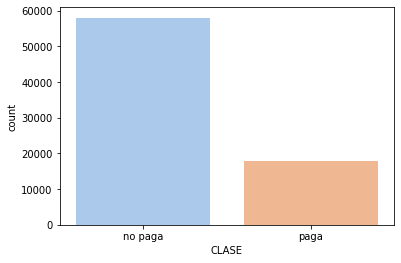

In [ ]:
# Veamos la distribución de la variable target 
print(df['CLASE'].value_counts(normalize = True)*100) # expresado en porcentajes
print(df['CLASE'].value_counts(normalize = False)) # expresado en nominal

sns.countplot(x='CLASE', data=df,  palette="pastel")

###1.a) Análisis de Missing Values o Nulos

In [ ]:
val_nulos = df.isnull().sum()
print(df.shape)
print(val_nulos)

(75966, 19)
ad_type                0
start_date             0
end_date               0
created_on             0
lat                11112
lon                11335
l1                     0
l2                     0
l3                  3129
l4                 46418
l5                 75087
l6                 75966
rooms              26056
bedrooms           24605
bathrooms           6793
surface_total      39507
surface_covered    34297
price_period       52137
CLASE                  0
dtype: int64


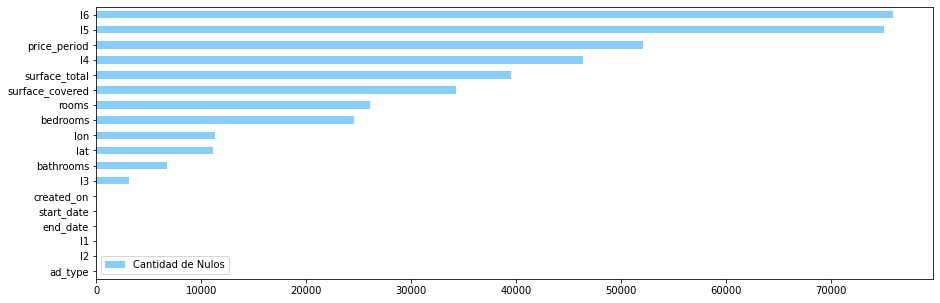

In [ ]:
# Graficamos la distribución de valores nulos en cada variable
atributos_nulos = (df.isnull()).sum(axis=0)
atributos_nulos = pd.DataFrame(atributos_nulos, columns=['Cantidad de Nulos'])
atributos_nulos = atributos_nulos.sort_values(by=['Cantidad de Nulos'], ascending=True)
atributos_nulos.drop(['CLASE'], inplace = True)
atributos_nulos.plot(kind='barh', figsize=(15,5), color='lightskyblue', grid=False)

Inmediatamente notamos que las variables l4 , l5 e l6 (barrio, sub-barrio y catastro respectivamente) son mayoritariamente nulas, la variable I6 esta vacia en todos los registros del set de datos, y la variable I5 en aproximadamente el 98.8%. Por lo que quizas sea lo mejor eliminar estas columnas en la etapa de preparacion de datos,

###1.b) Análisis de Outliers

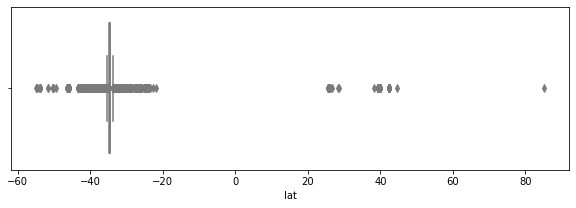

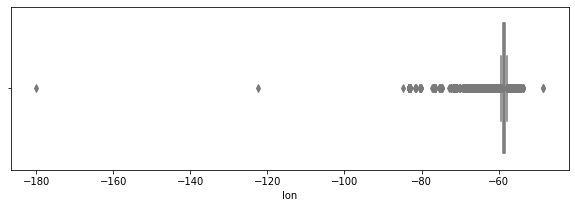

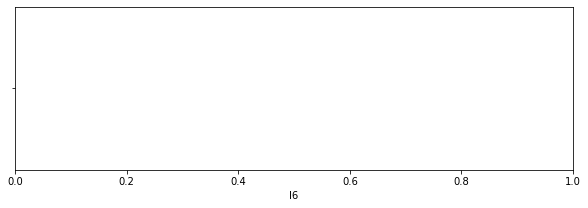

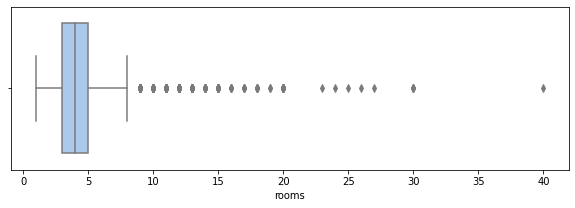

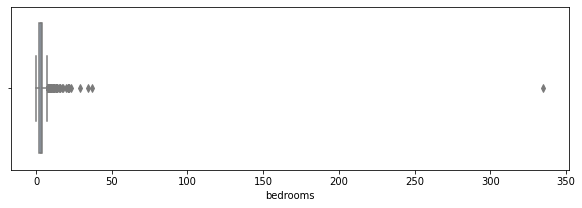

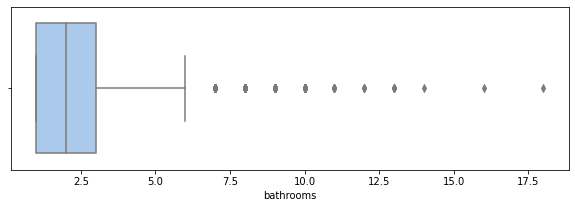

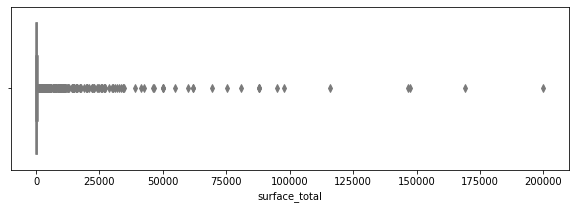

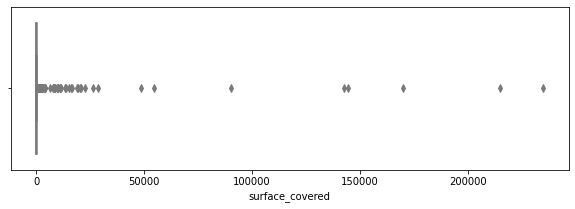

In [ ]:
# Creamos un gráfico boxplot para analizar las variables
for c in df.columns:
  if("float" in str(df.dtypes[c]) or "int" in str(df.dtypes[c])):
    plt.figure(figsize=(10, 3))
    sns.boxplot(x=c, data=df, orient = 'h', palette="pastel")

###1.c) Análisis de Correlación de Variables Numéricas

In [ ]:
# Creamos una variable numérica CLASE_NUM a partir de nuestra variable objetivo CLASE. 
# La misma tendrá un valor 1 cuando la propiedad paga comision y un valor 0 en caso contrario
# Esta variable se usará para calcular la correlacion lineal entre las variables númericas y la variable objetivo.
df['CLASE_NUM'] = list(map(lambda clase: 1 if (clase == 'paga') else 0, df['CLASE']))
# Calculamos la matriz de correlacion entre todas las variables del dataset. 
df.corr()

,lat,lon,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,CLASE_NUM
lat,1.000000,-0.468922,NaN,0.027201,0.010982,-0.038560,-0.001978,0.000178,-0.025389
lon,-0.468922,1.000000,NaN,-0.065174,0.002744,0.062421,-0.018119,0.000591,0.082291
l6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rooms,0.027201,-0.065174,NaN,1.000000,0.412326,0.519266,0.039890,0.046916,0.324616
bedrooms,0.010982,0.002744,NaN,0.412326,1.000000,0.354141,0.042078,0.050098,0.227512
bathrooms,-0.038560,0.062421,NaN,0.519266,0.354141,1.000000,0.053047,0.045414,0.551205
surface_total,-0.001978,-0.018119,NaN,0.039890,0.042078,0.053047,1.000000,0.206003,0.051798
surface_covered,0.000178,0.000591,NaN,0.046916,0.050098,0.045414,0.206003,1.000000,0.041174
CLASE_NUM,-0.025389,0.082291,NaN,0.324616,0.227512,0.551205,0.051798,0.041174,1.000000


In [ ]:
# Seleccionamos sólo la correlación de la variable objetivo numérica CLASE_NUM.
dfd = df.corr()[["CLASE_NUM"]]*100
dfd

,CLASE_NUM
lat,-2.538939
lon,8.229062
l6,NaN
rooms,32.461610
bedrooms,22.751164
bathrooms,55.120474
surface_total,5.179776
surface_covered,4.117437
CLASE_NUM,100.000000


In [ ]:
# Borramos la correlación de la variable objetivo numérica consigo misma.
dfd = dfd.drop("CLASE_NUM", axis=0)   # CLASE_NUM = 100

# Ordenamos las variables de forma decreciente por el valor de correlación positiva con la variable objetivo.
dfd = dfd.sort_values(["CLASE_NUM"], ascending=False)
dfd

,CLASE_NUM
bathrooms,55.120474
rooms,32.461610
bedrooms,22.751164
lon,8.229062
surface_total,5.179776
surface_covered,4.117437
lat,-2.538939
l6,NaN


Podemos ver que las variables que presentan una correlacion más clara son bathrooms (cantidad de baños) y rooms (Cantidad de ambientes).
Y que las variables de superficie (total y cubierta) y latitud y longitud no parecen tener una correlación tan notoria.

[]

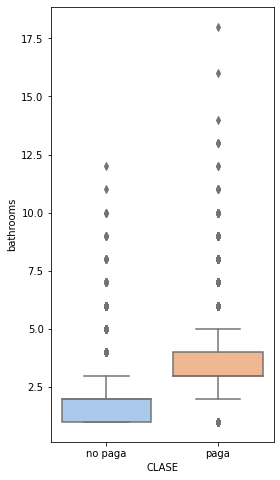

In [ ]:
# Creamos un gráfico boxplot para analizar la cantidad de baños respecto a la CLASE
plt.figure(figsize=(4, 8))
s=sns.boxplot(x="CLASE", y="bathrooms", data=df,  palette="pastel")
s.plot()

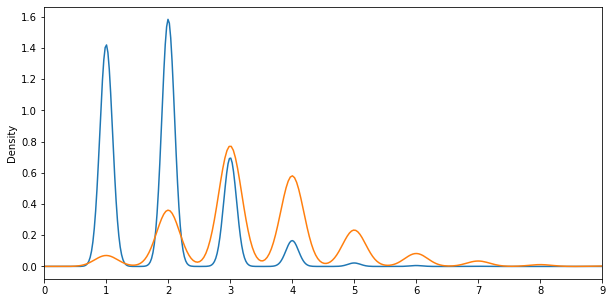

In [ ]:
fig = plt.figure(figsize=(10,5))
for paga in ['no paga','paga']:
    df.bathrooms[df.CLASE == paga ].plot(kind='kde')
plt.xlim(0, 9)
plt.show()

Podemos ver una clara correlacion entre la cantidad de baños de la propiedad y  la variable target.

[]

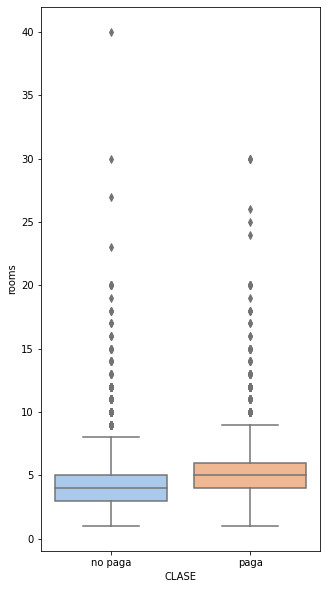

In [ ]:
plt.figure(figsize=(5, 10))
s=sns.boxplot(x="CLASE", y="rooms", data=df,  palette="pastel")
s.plot()

Como esperabamos tambien podemos ver una cierta correlacion entre la cantidad de ambientes y la variable target, esto no es una sorpresa ya que sabiamos que existia una correlacion de 0.52 entre la cantidad de ambientes y la cantidad de baños.

###1.d) Análisis de las variables categóricas de forma visual

#### Variable l1

In [ ]:
# El plan original era analizar con un grafico del tipo "swarmplot" algunas de 
# las variables categoricas, pero debido a las limitaciones de la herramienta,
# será mejor analizarlo con gráficos que requieran menos poder de procesamiento y memoria.

# plt.figure(figsize=(5, 10))
# s=sns.swarmplot(x="l1", y="l2", hue="CLASE", data=df, palette="pastel")
# s.plot()


<Figure size 360x720 with 0 Axes>

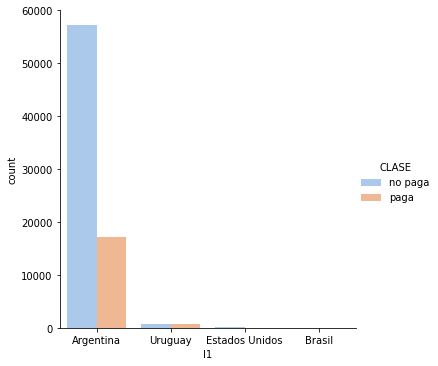

In [ ]:
plt.figure(figsize=(5, 10))
s= sns.catplot(x="l1", hue="CLASE",kind="count", data=df, palette="pastel")
#s.plot()

<Figure size 360x720 with 0 Axes>

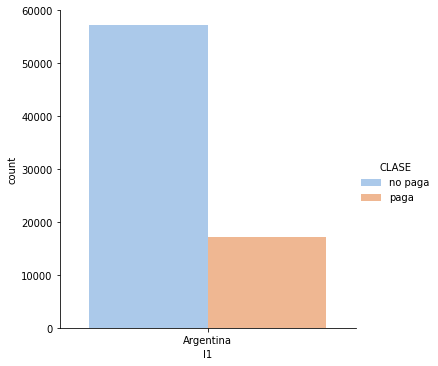

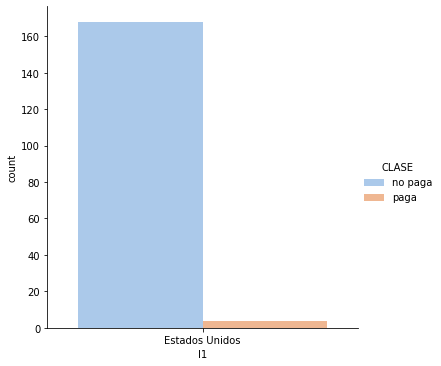

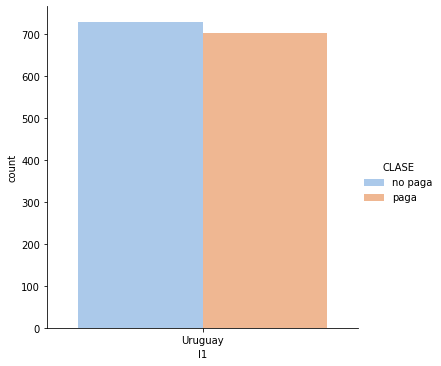

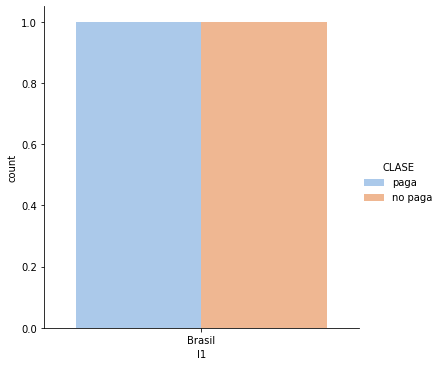

In [ ]:
plt.figure(figsize=(5, 10))
df_par = df[df['l1'] == 'Argentina']
df_peu = df[df['l1'] == 'Estados Unidos']
df_pur = df[df['l1'] == 'Uruguay']
df_pbr = df[df['l1'] == 'Brasil']
s= sns.catplot(x="l1", hue="CLASE",kind="count", data=df_par, palette="pastel")
s= sns.catplot(x="l1", hue="CLASE",kind="count", data=df_peu, palette="pastel")
s= sns.catplot(x="l1", hue="CLASE",kind="count", data=df_pur, palette="pastel")
s= sns.catplot(x="l1", hue="CLASE",kind="count", data=df_pbr, palette="pastel")

In [ ]:
#Expresado en porcentajes y en orden de deiferencia:
print("Estados Unidos")
print(df_peu['CLASE'].value_counts(normalize = True)*100)
print("Argentina")
print(df_par['CLASE'].value_counts(normalize = True)*100)
print("Uruguay")
print(df_pur['CLASE'].value_counts(normalize = True)*100)
print("Brasil")
print(df_pbr['CLASE'].value_counts(normalize = True)*100)

Estados Unidos
no paga    97.674419
paga        2.325581
Name: CLASE, dtype: float64
Argentina
no paga    76.865872
paga       23.134128
Name: CLASE, dtype: float64
Uruguay
no paga    50.979021
paga       49.020979
Name: CLASE, dtype: float64
Brasil
paga       50.0
no paga    50.0
Name: CLASE, dtype: float64


Podemos ver entonces que l1 es un indicador muy potente en Estados unidos y argentina, pero no tanto en Brasil y Uruguay. Podria ser valioso generar una dimension numerica que asocie la "probabilidad país"* del dataset, ya que vemos que una propiedad en estados unidos tiene 97% de probabilidad de no pagar.

\* Aclaracion: los valores expresados en porcentajes arriba no representan realmente una probabilidad, son simplemente la distribucion de las variables de este dataset. Pero pensamos que puede ser un indicador importante que tenga una fuerte relacion con la probabildiad de que se page o no comision en ese pais.

#### Variable ad_type


<Figure size 360x720 with 0 Axes>

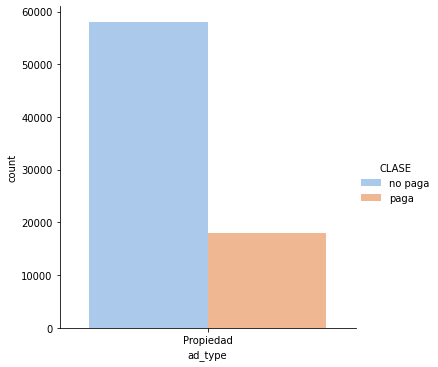

In [ ]:
plt.figure(figsize=(5, 10))
s= sns.catplot(x="ad_type", hue="CLASE",kind="count", data=df, palette="pastel")


Vemos que la variable solo indica "propiedad" y no posee ningun valor nulo, por lo que no es un indicador util

#2. Preparacion de datos

In [ ]:
df_2 = copy.copy(df)

### 2.a) Tratamiento de Outliers
En este punto vamos a imputar los valores Outliers de nuestro Dataset

In [ ]:
#Eliminamos los valores de superficies menores a 0, ya que no tienen sentido
#inicialmente podriamos pensar en llevar este valor a 0, pero como es evidente
#que estos valores son un error, los llevamos al promedio.
surface_total_mean = df['surface_total'].mean()
surface_covered_mean = df['surface_covered'].mean()
df_2['surface_total'] = df_2.apply(lambda x: surface_total_mean if x['surface_total']<0 else x['surface_total'], axis=1)
df_2['surface_covered'] = df_2.apply(lambda x: surface_covered_mean if x['surface_covered']<0 else x['surface_covered'], axis=1)

In [ ]:
#Impugnamos los valores superiores a 5 desvios estándar como outliers
surface_total_out = surface_total_mean + 5*df['surface_total'].std()
surface_covered_out = surface_total_mean + 5*df['surface_covered'].std()
bathrooms_out = df['bathrooms'].mean() + 5*df['bathrooms'].std()
bedrooms_out = df['bedrooms'].mean() + 5*df['bedrooms'].std()
rooms_out =df['rooms'].mean() + 5*df['rooms'].std()
df_2['surface_total'] = df_2.apply(lambda x: surface_total_out if x['surface_total']> surface_total_out else x['surface_total'], axis=1)
df_2['surface_covered'] = df_2.apply(lambda x: surface_covered_out if x['surface_covered']> surface_covered_out else x['surface_covered'], axis=1)
df_2['rooms'] = df_2.apply(lambda x: rooms_out if x['rooms']> rooms_out else x['rooms'], axis=1)
df_2['bathrooms'] = df_2.apply(lambda x: bathrooms_out if x['bathrooms']> bathrooms_out else x['bathrooms'], axis=1)
df_2['bedrooms'] = df_2.apply(lambda x: bedrooms_out if x['bedrooms']> bathrooms_out else x['bedrooms'], axis=1)

In [ ]:
df_2.describe()

,lat,lon,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,CLASE_NUM
count,64854.000000,64631.000000,0.0,49910.000000,51361.000000,69173.000000,36459.000000,41669.000000,75966.00000
mean,-34.443771,-59.353761,NaN,4.121102,2.974703,2.302672,453.666726,211.717363,0.23575
std,4.321409,2.832762,NaN,1.606471,1.200818,1.200061,869.207543,327.736166,0.42447
min,-54.828087,-180.000000,NaN,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000
25%,-34.807490,-58.816697,NaN,3.000000,2.000000,1.000000,170.000000,120.000000,0.00000
50%,-34.642029,-58.561035,NaN,4.000000,3.000000,2.000000,262.000000,175.000000,0.00000
75%,-34.421031,-58.378182,NaN,5.000000,4.000000,3.000000,480.000000,250.000000,0.00000
max,85.051129,-48.396729,NaN,12.517122,12.525901,8.360543,13733.785323,11228.878936,1.00000


### 2.b) Tratamiento de Nulos


Como destacamos en el analisis, las columnas l4, l5 y l6 son en su mayoria valores nulos, por esto decidimos eliminarlas y no intentar impugnarlas

In [ ]:
df_2.drop(['l6','l5','l4'], axis = 1, inplace=True)

Para las variables Surface_total y Surface_covered vamos a tener que impugnar los valores nulos, ya que no sabemos si estas variables podrian ser indicadores utiles o no.

In [ ]:
#Impugnamos los valores nulos como la media
rooms_mean = df['rooms'].mean()
bathrooms_mean = df['bathrooms'].mean()
bedrooms_mean = df['bedrooms'].mean()
df_2['surface_total'] = df_2.apply(lambda x: surface_total_mean if pd.isna(x['surface_total']) else x['surface_total'], axis=1)
df_2['surface_covered'] = df_2.apply(lambda x: surface_covered_mean if pd.isna(x['surface_covered']) else x['surface_covered'], axis=1)
df_2['rooms'] = df_2.apply(lambda x: rooms_mean if pd.isna(x['rooms']) else x['rooms'], axis=1)
df_2['bathrooms'] = df_2.apply(lambda x: bathrooms_mean if pd.isna(x['bathrooms']) else x['bathrooms'], axis=1)
df_2['bedrooms'] = df_2.apply(lambda x: bedrooms_mean if pd.isna(x['bedrooms']) else x['bedrooms'], axis=1)

La variable price_period solo posee un valor posible, al igual que lo hacia ad_type, pero en el caso de price_perdiod esta contiene en su mayoria valores nulos. 
Decidimos no descartar esta columna en su totalidad, y en su lugar la transformaremos en una variable booleana 1 = mensual y 2 = nulo y evaluaremos el modelo con esta variable en lugar de utilizar price_period.

In [ ]:
#Creamos la columna es_mensual que sera 1 si es mensual y 0 en cualquier otro caso:
df_2['es_mensual'] = pd.get_dummies(df['price_period'])
df_2.drop(['price_period'], axis = 1, inplace=True)
df_2.head(5)

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,CLASE,CLASE_NUM,es_mensual
id,,,,,,,,,,,,,,,,,
mSw0E1RIHFnJ1UjWmG2qtw==,Propiedad,2020-03-17,2020-06-10,2020-03-17,-34.664358,-58.587786,Argentina,Bs.As. G.B.A. Zona Oeste,La Matanza,4.000000,3.000000,3.000000,513.777037,238.344333,no paga,0,0
6xlrr/5ku0pbWrk03hLKrQ==,Propiedad,2020-06-30,2020-07-02,2020-06-30,-34.389184,-58.702997,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,4.129954,4.000000,4.000000,245.000000,210.000000,paga,1,0
GNsHGUGRZGO0M2/JBkrt6Q==,Propiedad,2019-12-12,9999-12-31,2019-12-12,-34.801070,-58.403177,Argentina,Bs.As. G.B.A. Zona Sur,Almirante Brown,4.129954,2.981484,1.000000,108.000000,108.000000,no paga,0,1
ec3j2TP5GfSGseuxOHdjSw==,Propiedad,2020-05-28,2020-06-10,2020-05-28,-34.760079,-58.420458,Argentina,Bs.As. G.B.A. Zona Sur,Lomas de Zamora,1.000000,1.000000,2.304396,513.777037,238.344333,no paga,0,0
JeE2usc8v3Tfj/ZA/ifAEw==,Propiedad,2020-01-16,2020-04-28,2020-01-16,NaN,NaN,Argentina,Mendoza,San Rafael,4.129954,2.981484,1.000000,513.777037,238.344333,no paga,0,0


### 2.c) Tratamiento de variables Categóricas
Comenzamos eliminando ad_type, porqye sabemos que es igual para todos los registros

In [ ]:
df_2.drop(['ad_type'], axis = 1, inplace=True)

In [ ]:
df_num = copy.copy(df_2)

In [ ]:
df_num.dtypes

start_date         datetime64[ns]
end_date                   object
created_on         datetime64[ns]
lat                       float64
lon                       float64
l1                         object
l2                         object
l3                         object
rooms                     float64
bedrooms                  float64
bathrooms                 float64
surface_total             float64
surface_covered           float64
CLASE                      object
CLASE_NUM                   int64
es_mensual                  uint8
dtype: object

En esta primera iteracion no vamos a trabajar con las variables de fecha, ni con l2 y l3, ya que las mismas generan alta dimensionalidad en el dataset, si no consiguiesemos un modelo lo suficientemente bueno, deberemos adentrarnos en como interpretar estas variables.

In [ ]:
df_num.drop(['l3','CLASE','start_date','end_date','created_on'], axis = 1, inplace=True)

Encontramos que la variable l1 posee informacion util, por lo que vamos a reemplazar la variable categorica l1 por una variable numérica 'probabilidad_pais' (que no representa una probabilidad, simplemente un score asociado a la distribucion que enconrtamos en esos paises), para poder utilizarlo en nuestros modelos.

In [ ]:
pp_eeuu = (df_peu['CLASE'].value_counts(normalize = True))['paga'] *100
pp_ar = (df_par['CLASE'].value_counts(normalize = True))['paga'] *100
pp_ur = (df_pur['CLASE'].value_counts(normalize = True))['paga'] *100
pp_br = (df_pbr['CLASE'].value_counts(normalize = True))['paga'] * 100

df_num['probabilidad_pais'] = list(map(lambda clase: pp_eeuu if (clase == 'Estados Unidos') else 0, df_num['l1']))
df_num['probabilidad_pais'] = df_num.apply(lambda x: pp_ar if x['l1']=='Argentina' else x['probabilidad_pais'], axis=1)
df_num['probabilidad_pais'] = df_num.apply(lambda x: pp_ur if x['l1']=='Uruguay' else x['probabilidad_pais'], axis=1)
df_num['probabilidad_pais'] = df_num.apply(lambda x: pp_br if x['l1']=='Brasil' else x['probabilidad_pais'], axis=1)
df_num.drop(['l1'], axis = 1, inplace=True)

Ahora si, verificamos y efectivamente contamos con un dataset con todas columnas numéricas

In [ ]:
#df_num.describe(include='all')
df_num.dtypes

lat                  float64
lon                  float64
l2                    object
rooms                float64
bedrooms             float64
bathrooms            float64
surface_total        float64
surface_covered      float64
CLASE_NUM              int64
es_mensual             uint8
probabilidad_pais    float64
dtype: object

In [ ]:
dicc_l2 = { 'nulo': -1}
for zona in pd.unique(df_num['l2']):
  dicc_l2[zona] = ((df[df['l2'] == zona])['CLASE'].value_counts(normalize = True))['no paga'] *100
for x in dicc_l2:
  print(x + str( dicc_l2.get(x)) )

nulo-1
Bs.As. G.B.A. Zona Oeste87.34249713631156
Bs.As. G.B.A. Zona Norte58.54054852528435
Bs.As. G.B.A. Zona Sur84.59110131633808
Mendoza88.35690968443961
Córdoba88.23773898586866
Capital Federal58.36058425986484
Colonia71.02803738317756
Santa Fe89.79988882712618
Buenos Aires Costa Atlántica83.5919011306863
Maldonado40.399556048834626
Neuquén79.04109589041096
Buenos Aires Interior87.13854121709107
San Luis93.38235294117648
Canelones74.53416149068323
Misiones93.4959349593496
Montevideo65.4471544715447
Río Negro80.10204081632652
Corrientes89.39393939393939
Entre Ríos96.9620253164557
Tierra Del Fuego94.44444444444444
Tucumán89.57528957528957
Chubut93.15068493150685
Michigan98.82352941176471
Rocha53.333333333333336
San Juan91.42857142857143
Salta86.6906474820144
La Pampa97.91666666666666
Chaco93.33333333333333
Santiago Del Estero62.5
Jujuy74.07407407407408
Maryland98.24561403508771
Catamarca80.0
Florida84.61538461538461
Formosa100.0
Pennsylvania100.0
Santa Cruz95.1219512195122
La Rioja100

### 2.4) Feature Engineering
Planteo algunas posibles variables que podrian o no resultar utiles:
* Porcentaje de superficie cubierta:  surface_covered * 100  / surface_total 
* Porcentaje de ambientes que son baños:  bathrooms * 100  / rooms
* variable "booleana", indica si la propiedad esta en estados unidos.

In [ ]:
df_num['porcentaje_surface'] = df_num.apply(lambda x: 0 if x['surface_total']<= 0 else (x['surface_covered']/x['surface_total'])*100, axis=1)
df_num['porcentaje_bathrooms'] = df_num.apply(lambda x: 0 if x['rooms']<= 0 else (x['bathrooms']/x['rooms'])*100, axis=1)
df_num['es_eeuu'] = df_2.apply(lambda x: 1 if x['l1']=='Estados Unidos' else 0, axis=1)

In [ ]:
dfd = df_num.corr()[["CLASE_NUM"]]*100
dfd = dfd.drop("CLASE_NUM", axis=0)
dfd = dfd.sort_values(["CLASE_NUM"], ascending=False)
dfd

,CLASE_NUM
bathrooms,53.435529
bedrooms,30.768624
porcentaje_bathrooms,29.303141
rooms,25.357327
surface_covered,16.820952
es_mensual,10.763151
surface_total,9.245662
probabilidad_pais,8.630318
lon,8.229062
porcentaje_surface,2.930029


Generamos estas tres variables y por la correlacion con la variable objetivo podriamos inferir que la variables de porcentaje de superficie cubierta y es_eeuu no resultaran tan utiles.

Dejaremos sin embargo una funcion las genere  y para realizar las pruebas y verificar si es efectivamente resulta util o solamente tiene correlacion alta porque prte de una variable con correlación alta.

In [ ]:
def add_VariablesCompuestas(df_a):
  df_b = copy.copy(df_a)
  df_b['porcentaje_bathrooms'] = df_b.apply(lambda x: 0 if x['rooms']<= 0 else (x['bathrooms']/x['rooms'])*100, axis=1)
  df_b['porcentaje_surface'] = df_b.apply(lambda x: 0 if x['surface_total']<= 0 else (x['surface_covered']/x['surface_total'])*100, axis=1)
  df_b['es_eeuu'] = df_b.apply(lambda x: 1 if x['l1']=='Estados Unidos' else 0, axis=1)
  return df_b

### 2.5) Latitud y Longitud

Se decidio no utilizar estas variables en el modelo, ya que presentaban algunos valores nulos que no son compatibles con las estrategias elegidas.

Para utilizar las variables latitud y longitud se podria haber realizado una funcion que reemplaze los nulos por un valor dependiendo de la variable l2, pero por restricciones de tiempo (y mi destreza con python) opte por dejarlas afuera.

In [ ]:
  df_par = df[df['l1'] == 'Argentina']
  df_peu = df[df['l1'] == 'Estados Unidos']
  df_pur = df[df['l1'] == 'Uruguay']
  df_pbr = df[df['l1'] == 'Brasil']
  print(df_par['lat'].mean());  print(df_par['lon'].mean())
  print(df_peu['lat'].mean());  print(df_peu['lon'].mean())
  print(df_pur['lat'].mean());  print(df_pur['lon'].mean())
  print(df_pbr['lat'].mean());  print(df_pbr['lon'].mean())

-34.636771029853726
-59.37843160735844
39.616096871677875
-79.92052894163433
-34.84281120420783
-55.468859424850095
-27.416746005
-48.462415660000005


In [ ]:
def lat_x_pais( pais ):
  if( pais =='Argentina'):
    return df_par['lat'].mean()
  elif( pais == 'Estados Unidos'):
    return df_peu['lat'].mean()
  elif( pais == 'Uruguay' ):
    return df_pur['lat'].mean()
  elif( pais == 'Brasil' ):
    return df_par['lat'].mean()
  return 0

def lon_x_pais( pais ):
  if( pais =='Argentina'):
    return df_par['lon'].mean()
  elif( pais == 'Estados Unidos'):
    return df_peu['lon'].mean()
  elif( pais == 'Uruguay' ):
    return df_pur['lon'].mean()
  elif( pais == 'Brasil' ):
    return df_par['lon'].mean()
  return 0

###2.6) Funcion de preparacion de datos

In [ ]:
def preparacion_de_datos(df_e, imputar_ouliers, imputar_nulos, agregar_VariablesCompuestas, agregar_variables_probabilidad= True, coef_outliers = 3 ):
  df_s = copy.copy(df_e)
  df_s['CLASE'] = df_s['paga_comision']
  df_s.drop(["paga_comision"], axis=1, inplace=True)
  df_s.set_index( 'id', inplace=True)

  surface_total_mean = df_s['surface_total'].mean()
  surface_covered_mean = df_s['surface_covered'].mean()
  if imputar_nulos:
    #nulos
    df_s.drop(['l6','l5','l4'], axis = 1, inplace=True)
    df_s['surface_total'] = df_s.apply(lambda x: -1 if pd.isna(x['surface_total']) else x['surface_total'], axis=1)
    df_s['surface_covered'] = df_s.apply(lambda x: -1 if pd.isna(x['surface_covered']) else x['surface_covered'], axis=1)
    df_s['rooms'] = df_s.apply(lambda x: -1 if pd.isna(x['rooms']) else x['rooms'], axis=1)
    df_s['bathrooms'] = df_s.apply(lambda x: -1 if pd.isna(x['bathrooms']) else x['bathrooms'], axis=1)
    df_s['bedrooms'] = df_s.apply(lambda x: -1 if pd.isna(x['bedrooms']) else x['bedrooms'], axis=1)
    df_s['lat'] = df_s.apply(lambda x: lat_x_pais( x['l1'] ) if pd.isna(x['lat']) else x['lat'], axis=1)
    df_s['lon'] = df_s.apply(lambda x: lon_x_pais( x['l1'] ) if pd.isna(x['lon']) else x['lon'], axis=1)
    #df_s['l1'] = df_s.apply(lambda x: 'Nulo' if pd.isna(x['l1']) else x['l1'], axis=1)
    #df_s['l2'] = df_s.apply(lambda x: 'Nulo' if pd.isna(x['l2']) else x['l2'], axis=1)
    #df_s.drop(['lat','lon'], axis = 1, inplace=True)
  
  #variables inutiles
  df_s.drop(['title'], axis = 1, inplace=True)
  if imputar_ouliers:
    #outliers (menos que el minimo)
    df_s['surface_total'] = df_s.apply(lambda x: surface_total_mean if x['surface_total']<0 else x['surface_total'], axis=1)
    df_s['surface_covered'] = df_s.apply(lambda x: surface_covered_mean if x['surface_covered']<0 else x['surface_covered'], axis=1)
    #outliers (más que el máximo)
    surface_total_out = surface_total_mean + coef_outliers*df_s['surface_total'].std()
    surface_covered_out = surface_total_mean + coef_outliers*df_s['surface_covered'].std()
    bathrooms_out = df_s['bathrooms'].mean() + coef_outliers*df_s['bathrooms'].std()
    bedrooms_out = df_s['bedrooms'].mean() + coef_outliers*df_s['bedrooms'].std()
    rooms_out =df_s['rooms'].mean() + coef_outliers*df['rooms'].std()
    df_s['surface_total'] = df_s.apply(lambda x: surface_total_out if x['surface_total']> surface_total_out else x['surface_total'], axis=1)
    df_s['surface_covered'] = df_s.apply(lambda x: surface_covered_out if x['surface_covered']> surface_covered_out else x['surface_covered'], axis=1)
    df_s['rooms'] = df_s.apply(lambda x: rooms_out if x['rooms']> rooms_out else x['rooms'], axis=1)
    df_s['bathrooms'] = df_s.apply(lambda x: bathrooms_out if x['bathrooms']> bathrooms_out else x['bathrooms'], axis=1)
    df_s['bedrooms'] = df_s.apply(lambda x: bedrooms_out if x['bedrooms']> bathrooms_out else x['bedrooms'], axis=1)
    
    #variables compuestas
  if agregar_VariablesCompuestas:
    df_s = add_VariablesCompuestas(df_s)
  df_s['es_mensual'] = df_s.apply(lambda x: 0 if pd.isna(x['price_period']) else 1, axis=1)
  df_s.drop(['price_period'], axis = 1, inplace=True)

 
 #categoricas
  df_s.drop(['ad_type'], axis = 1, inplace=True)
  df_s.drop(['l3','CLASE','start_date','end_date','created_on'], axis = 1, inplace=True)
  #df_s.drop(['l3','CLASE','start_date','end_date','created_on'], axis = 1, inplace=True)

  if agregar_variables_probabilidad:
    df_par = df[df['l1'] == 'Argentina']
    df_peu = df[df['l1'] == 'Estados Unidos']
    df_pur = df[df['l1'] == 'Uruguay']
    df_pbr = df[df['l1'] == 'Brasil']
    pp_eeuu = float(2.32)
    pp_ar = float(23.13)
    pp_ur = float(49.02)
    pp_br = float(50.0)
    df_s['probabilidad_pais'] = list(map(lambda clase: pp_eeuu if (clase == 'Estados Unidos') else 0, df_s['l1']))
    df_s['probabilidad_pais'] = df_s.apply(lambda x: pp_ar if x['l1']=='Argentina' else x['probabilidad_pais'], axis=1)
    df_s['probabilidad_pais'] = df_s.apply(lambda x: pp_ur if x['l1']=='Uruguay' else x['probabilidad_pais'], axis=1)
    df_s['probabilidad_pais'] = df_s.apply(lambda x: pp_br if x['l1']=='Brasil' else x['probabilidad_pais'], axis=1)
    df_s.drop(['l1'], axis = 1, inplace=True)

    dicc_l2 = { 'nulo': -1}
    for zona in pd.unique(df_num['l2']):
      dicc_l2[zona] = ((df[df['l2'] == zona])['CLASE'].value_counts(normalize = True))['no paga'] *100
    df_s['probabilidad_zona'] = list(map(lambda clase: dicc_l2.get(clase) , df_s['l2']))
    df_s.drop(['l2'], axis = 1, inplace=True)

  return df_s

# 3. Construccion del modelo predictivo no optimizado

In [ ]:
df_c = pd.read_csv(dataset_entrenamiento, sep =',', na_values = '.', parse_dates=['start_date','end_date','created_on'])
df_c['CLASE_NUM'] = list(map(lambda clase: 1 if (clase == 'paga') else 0, df['CLASE']))
df_x1 = preparacion_de_datos( df_c, True ,True, False, False, 2)

# Encodeamos todos los atributos categóricos como booleanos con la función pd.get_dummies (sin incluir la variable objetivo). 
X  = pd.get_dummies(df_x1.drop(['CLASE_NUM'], axis=1),dummy_na=False)
atributos = X.columns

# Encodeamos las etiquetas usando LabelEncoder
# Convertimos la variable objetivo en una variable booleana de valores 0 o 1 para simplificar los cálculos
le = LabelEncoder()
y = le.fit_transform(df_x1['CLASE_NUM'])

# Dividimos el dataset en entrenamiento y prueba (70% para training y 30% para testing)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42)

X_train.head(5)

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,es_mensual,l1_Argentina,l1_Brasil,l1_Estados Unidos,l1_Uruguay,l2_Bs.As. G.B.A. Zona Norte,l2_Bs.As. G.B.A. Zona Oeste,l2_Bs.As. G.B.A. Zona Sur,l2_Buenos Aires Costa Atlántica,l2_Buenos Aires Interior,l2_Canelones,l2_Capital Federal,l2_Catamarca,l2_Chaco,l2_Chubut,l2_Colonia,l2_Corrientes,l2_Córdoba,l2_Entre Ríos,l2_Florida,l2_Formosa,l2_Jujuy,l2_La Pampa,l2_La Rioja,l2_Maldonado,l2_Maryland,l2_Mendoza,l2_Miami,l2_Michigan,l2_Misiones,l2_Montevideo,l2_Neuquén,l2_Pennsylvania,l2_Rocha,l2_Río Negro,l2_Salta,l2_San Juan,l2_San Luis,l2_Santa Catarina,l2_Santa Cruz,l2_Santa Fe,l2_Santiago Del Estero,l2_Tierra Del Fuego,l2_Tucumán
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
QanvXCJB+ouqcQiwcEw/Xw==,-34.413843,-58.846868,-1.0,4.0,4.992188,439.000000,352.000000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
TjWMJkQbrNlJkAF0EhviAg==,-34.636771,-59.378432,-1.0,-1.0,2.000000,513.777037,238.344333,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
cxXDQHtqbdfqyvorRIIEdg==,-34.552052,-58.732590,3.0,-1.0,3.000000,180.000000,180.000000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BeyrxMQheFV1LyJUYwCAjQ==,-34.794012,-58.145542,4.0,3.0,3.000000,300.000000,238.344333,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3QyeIOpnPUdefRMvOhRSzQ==,-34.435997,-58.646104,4.0,3.0,3.000000,514.000000,200.000000,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn import preprocessing
def escalar( X_train ):
  X_scaled = copy.copy(X_train)
  X_scaled -= X_scaled.min()
  X_scaled /= X_scaled.max()
  X_scaled.fillna(0, inplace=True)
  return X_scaled

### Construcción del Arbol

In [ ]:
# Ajustamos un árbol de clasificación con max_depth=3
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

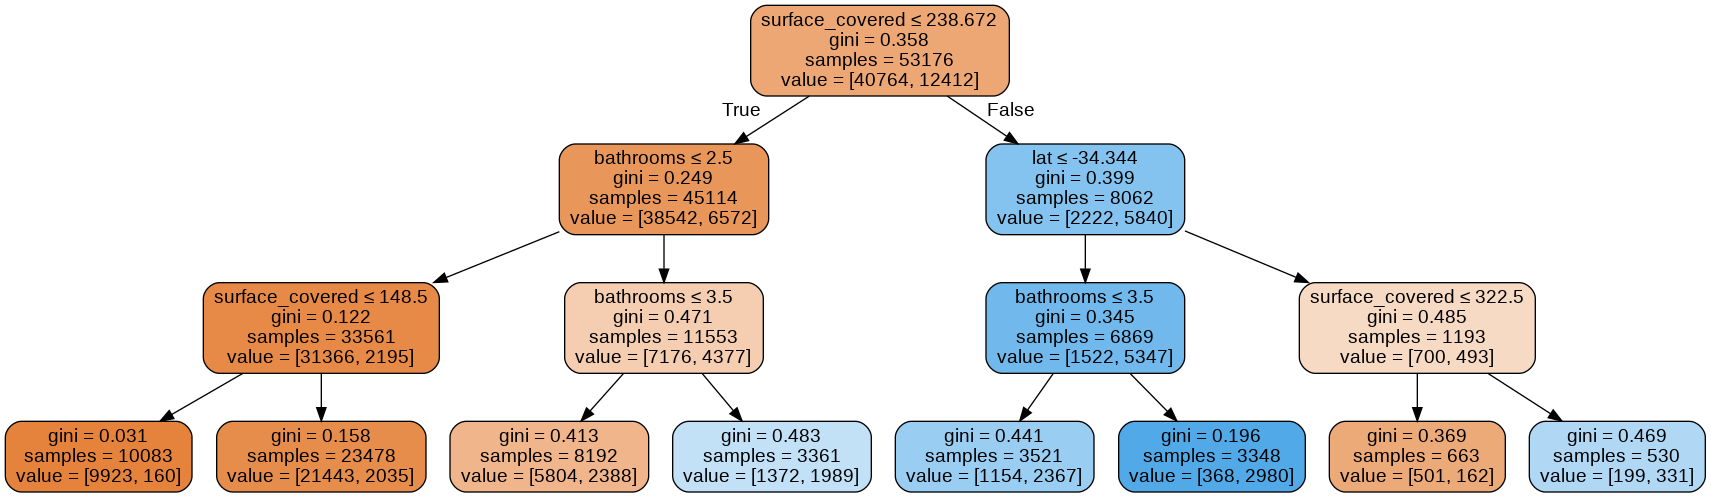

In [ ]:
# Visualizamos el árbol de decisión usando graphviz
dot_data = export_graphviz(treeclf, out_file=None,  
                feature_names=atributos,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

#### Analisis del Arbol
Podemos ver que las variables de superficie cubierta y cantidad de baños parecen ser tan relevantes que son las únicas que utiliza este primer modelo.

In [ ]:
print("el modelo acerto " + str((np.mean(treeclf.predict(X_test) == y_test))*100) + "% de los casos")

el modelo acerto 84.78718736287846% de los casos


#### Analisis de la curva ROC

AUC - Area Under the Curve - Área Bajo la Curva: 0.8575400852902622


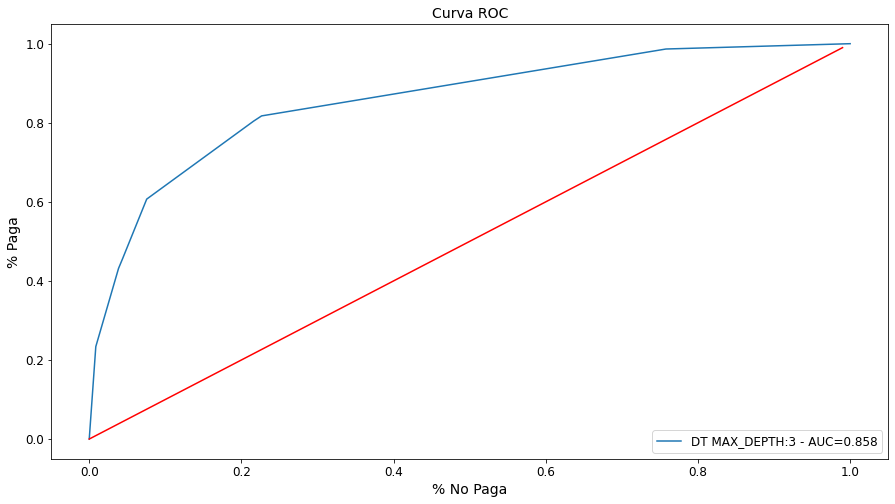

In [ ]:
plt.figure(figsize=(15, 8))

y_pred_proba = treeclf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print("AUC - Area Under the Curve - Área Bajo la Curva: {}".format(auc))

# Graficamos la curva roc del arbol
plt.plot(fpr,tpr,label="DT MAX_DEPTH:3 - AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR, AUC=0.5",color="red")

plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

Podemos ver que este modelo, a pesar de ser bastante sencillo, consigue un area debajo de la curva bastante bueno, ≈0.86.

En un analisis más minucioso podemos ver que el modelo consigue una prediccion bastante buena al principio, con una pendiente bastante marcada al principio.

Tambien vemos que este modelo sería inutil para casos mas alla del [0.2 no paga, 0.8 paga] , ya que ahi la pendiente comienza a ser incluso peor que si lo decidieramos de forma aleatoria.


#### Evaluacion del modelo de Arbol

In [ ]:
# Calculamos y mostramos la matriz de confusión del modelo
y_pred = treeclf.predict(X_test)
conf = confusion_matrix(y_test, y_pred)

predicted_cols = ['pred_'+str(c) for c in le.classes_]
pd.DataFrame(conf, index = le.classes_, columns = predicted_cols)

,pred_0,pred_1
0,15987,1306
1,2161,3336


In [ ]:
# Reporte del clasificador
from sklearn.metrics import classification_report
print('Exactitud (accuracy) del modelo: {:.2f} %'.format(accuracy_score(y_test, y_pred)*100))
print(classification_report(y_test, y_pred))

Exactitud (accuracy) del modelo: 84.79 %
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     17293
           1       0.72      0.61      0.66      5497

    accuracy                           0.85     22790
   macro avg       0.80      0.77      0.78     22790
weighted avg       0.84      0.85      0.84     22790



### Regresion Logística
Para una regresion logística es importante que los datos esten normalizados, por lo que creo la funcion "escalar()" que pasa los valores de un dataframe a valores de 0 a 1

In [ ]:
# Importamos la librería que necesitamos
from sklearn.linear_model import LogisticRegression # regresión logística para clasificación
from sklearn.metrics import accuracy_score # métrica de evaluación
X_train_s = escalar(X_train)
X_test_s = escalar(X_test)
RegLog = LogisticRegression(max_iter=600)
RegLog.fit(X_train_s,y_train) # Creamos y entrenamos el clasificador de regresión logística

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=600,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#vemos que el dataframe tiene todas las variables normalizadas a valores de 0 (min) a 1 (max)
X_train_s.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,es_mensual,l1_Argentina,l1_Brasil,l1_Estados Unidos,l1_Uruguay,l2_Bs.As. G.B.A. Zona Norte,l2_Bs.As. G.B.A. Zona Oeste,l2_Bs.As. G.B.A. Zona Sur,l2_Buenos Aires Costa Atlántica,l2_Buenos Aires Interior,l2_Canelones,l2_Capital Federal,l2_Catamarca,l2_Chaco,l2_Chubut,l2_Colonia,l2_Corrientes,l2_Córdoba,l2_Entre Ríos,l2_Florida,l2_Formosa,l2_Jujuy,l2_La Pampa,l2_La Rioja,l2_Maldonado,l2_Maryland,l2_Mendoza,l2_Miami,l2_Michigan,l2_Misiones,l2_Montevideo,l2_Neuquén,l2_Pennsylvania,l2_Rocha,l2_Río Negro,l2_Salta,l2_San Juan,l2_San Luis,l2_Santa Catarina,l2_Santa Cruz,l2_Santa Fe,l2_Santiago Del Estero,l2_Tierra Del Fuego,l2_Tucumán
count,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000,53176.000000
mean,0.145563,0.916738,0.483011,0.362957,0.498034,0.112073,0.059532,0.313468,0.978787,0.000038,0.002332,0.018843,0.266737,0.137807,0.221641,0.100064,0.030653,0.002106,0.060178,0.000169,0.000414,0.000921,0.001335,0.000809,0.063863,0.005059,0.000132,0.000132,0.000320,0.000583,0.000094,0.012092,0.000865,0.012054,0.000038,0.001091,0.003272,0.003197,0.009967,0.000207,0.000113,0.005228,0.003554,0.000470,0.003310,0.000038,0.000508,0.047409,0.000132,0.000207,0.003235
std,0.028996,0.020100,0.377644,0.289608,0.236886,0.082566,0.035180,0.463907,0.144094,0.006133,0.048234,0.135972,0.442258,0.344700,0.415355,0.300088,0.172377,0.045846,0.237818,0.013009,0.020336,0.030342,0.036516,0.028425,0.244512,0.070945,0.011473,0.011473,0.017877,0.024138,0.009696,0.109297,0.029399,0.109129,0.006133,0.033008,0.057110,0.056451,0.099337,0.014381,0.010622,0.072116,0.059512,0.021678,0.057436,0.006133,0.022528,0.212513,0.011473,0.014381,0.056782
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.143333,0.916554,0.000000,0.000000,0.333768,0.065595,0.044208,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.144348,0.922178,0.594772,0.396600,0.500652,0.122997,0.064372,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.145679,0.924038,0.743465,0.528800,0.667536,0.122997,0.064372,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [ ]:
pd.DataFrame({'Atributo':X_train_s.columns,
              'importancia':RegLog.coef_[0]}).sort_values('importancia', ascending=False).head(10)

,Atributo,importancia
6,surface_covered,23.735522
4,bathrooms,4.262225
18,l2_Capital Federal,1.683782
5,surface_total,1.451638
12,l2_Bs.As. G.B.A. Zona Norte,1.126924
11,l1_Uruguay,1.111652
28,l2_Jujuy,1.071404
38,l2_Neuquén,0.966929
0,lat,0.884681
31,l2_Maldonado,0.817682


#### Analisis de la Regresion
Podemos ver que la regresion logistica le da importancia a distintas variables, y en este caso le da valor a la variable que indicaba si el periodo de precio es mensual o no. ademas detecta un coeficiente negativo entre la variable probabilidad_pais y el target.

In [ ]:
#si X_test_s contiene nulos los reemplazamos por 0
#cuando un pais (brasil usualmente) no aparece en el conjunto test por el split
X_test_s.fillna(0, inplace=True)

In [ ]:
print("el modelo acerto " + str((np.mean(RegLog.predict(X_test_s) == y_test))*100) + "% de los casos")

el modelo acerto 84.0895129442738% de los casos


#### Analisis de la Curva ROC

AUC - Area Under the Curve - Área Bajo la Curva: 0.8660654769494609


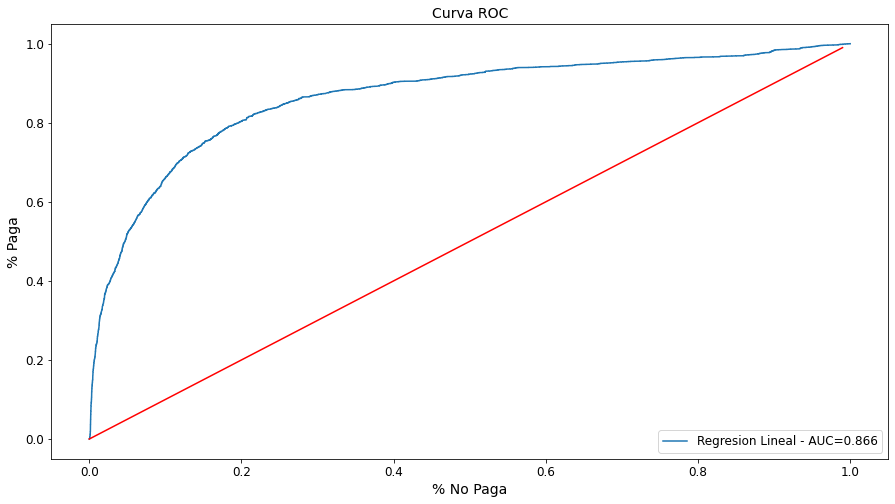

In [ ]:
plt.figure(figsize=(15, 8))

y_pred_RLog = RegLog.predict_proba(X_test_s)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_RLog)
auc = metrics.roc_auc_score(y_test, y_pred_RLog)
print("AUC - Area Under the Curve - Área Bajo la Curva: {}".format(auc))

# Graficamos la curva roc del modelo de regresion
plt.plot(fpr,tpr,label="Regresion Lineal - AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR, AUC=0.5",color="red")

plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

####Evaluacion del modelo de Regresion Logistica

In [ ]:
# Predigo los valores
y_pred_RLog = RegLog.predict(X_test_s)

#Exactitud del modelo
print('Exactitud (accuracy) del modelo: {:.2f} %'.format(accuracy_score(y_test, y_pred_RLog)*100))
print("-"*100)

# Reporte del clasificador
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_RLog))

Exactitud (accuracy) del modelo: 84.09 %
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     17293
           1       0.78      0.47      0.59      5497

    accuracy                           0.84     22790
   macro avg       0.82      0.72      0.75     22790
weighted avg       0.83      0.84      0.83     22790



### Vecinos más cercanos

In [ ]:
#PARAMETROS = {'n_neighbors': np.arange(3, 10)}
#k_n_jobs = 2

#model = KNeighborsClassifier()
#knn_gs = GridSearchCV(model, PARAMETROS, verbose=1, scoring=f_ganancia, n_jobs=k_n_jobs,
#                      cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=1)) 

from sklearn.neighbors import KNeighborsClassifier
X_train_s = escalar(X_train)
X_test_s = escalar(X_test)
knn = KNeighborsClassifier()
knn.fit(X_train_s,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
print("el modelo acerto " + str((np.mean(knn.predict(X_test_s) == y_test))*100) + "% de los casos")

el modelo acerto 84.3483984203598% de los casos


AUC - Area Under the Curve - Área Bajo la Curva: 0.7681838906132394


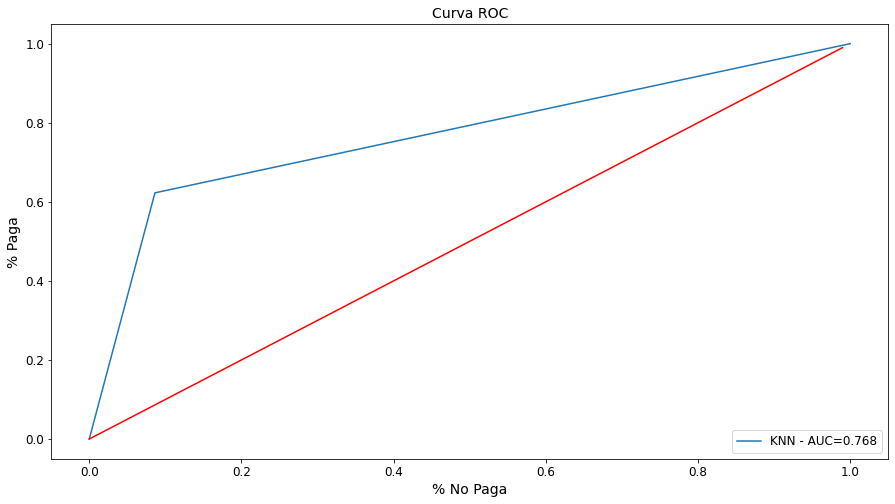

In [ ]:
plt.figure(figsize=(15, 8))

y_pred_bay = knn.predict(X_test_s)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_bay)
auc = metrics.roc_auc_score(y_test, y_pred_bay)
print("AUC - Area Under the Curve - Área Bajo la Curva: {}".format(auc))

# Graficamos la curva roc del modelo Naive Bayes
plt.plot(fpr,tpr,label="KNN - AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR, AUC=0.5",color="red")

plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

### Naive bayes

In [ ]:
# Importamos la librería que necesitamos
from sklearn.naive_bayes import GaussianNB # naive bayes Gausiano

# Creamos y entrenamos el clasificador bayesiano
bayes = GaussianNB() 
bayes.fit(X_train_s, y_train) # entrenamos el clasificador

GaussianNB(priors=None, var_smoothing=1e-09)

#### Analisis del Modelo Naive Bayes

In [ ]:
print("el modelo acerto " + str((np.mean(bayes.predict(X_test_s) == y_test))*100) + "% de los casos")

el modelo acerto 36.34488810881965% de los casos


#### Analisis de la Curva ROC

AUC - Area Under the Curve - Área Bajo la Curva: 0.684995830143274


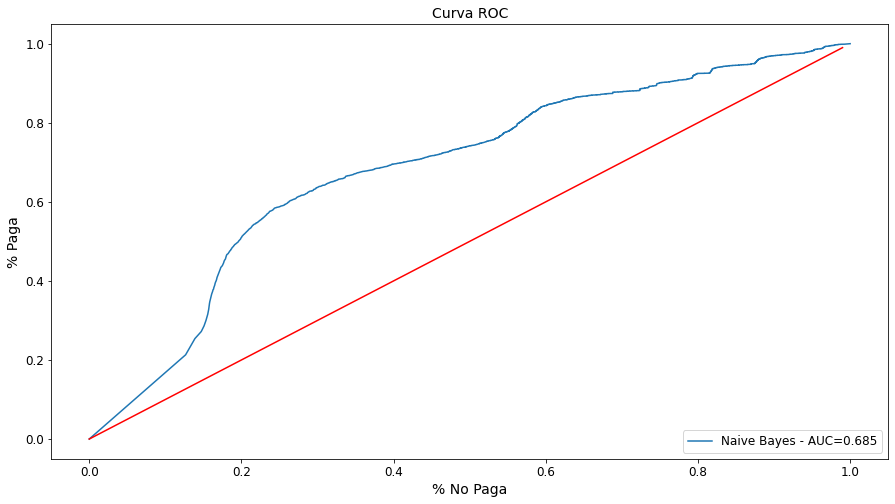

In [ ]:
plt.figure(figsize=(15, 8))

y_pred_bay = bayes.predict_proba(X_test_s)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_bay)
auc = metrics.roc_auc_score(y_test, y_pred_bay)
print("AUC - Area Under the Curve - Área Bajo la Curva: {}".format(auc))

# Graficamos la curva roc del modelo Naive Bayes
plt.plot(fpr,tpr,label="Naive Bayes - AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR, AUC=0.5",color="red")

plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

### Comparacion entre los modelos

AUC - Area Under the Curve - Área Bajo la Curva knn: 0.8598705490315388
AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision: 0.8575400852902622
AUC - Area Under the Curve - Área Bajo la Curva Modelo de Regresion: 0.8660654769494609
AUC - Area Under the Curve - Área Bajo la Curva: 0.684995830143274


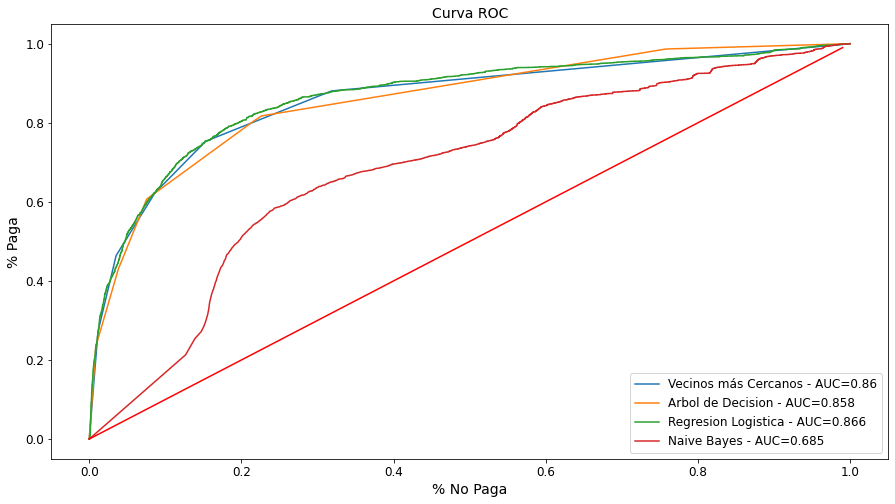

In [ ]:
plt.figure(figsize=(15, 8))

# Graficamos la curva roc del modelo knn
y_pred_bay = knn.predict_proba(X_test_s)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_bay)
auc = metrics.roc_auc_score(y_test, y_pred_bay)
print("AUC - Area Under the Curve - Área Bajo la Curva knn: {}".format(auc))
plt.plot(fpr,tpr,label="Vecinos más Cercanos - AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la curva roc del arbol
y_pred_proba = treeclf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print("AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision: {}".format(auc))
plt.plot(fpr,tpr,label="Arbol de Decision - AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la curva roc del modelo de regresion
y_pred_RLog = RegLog.predict_proba(X_test_s)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_RLog)
auc = metrics.roc_auc_score(y_test, y_pred_RLog)
print("AUC - Area Under the Curve - Área Bajo la Curva Modelo de Regresion: {}".format(auc))
plt.plot(fpr,tpr,label="Regresion Logistica - AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la curva roc del modelo Naive Bayes
y_pred_bay = bayes.predict_proba(X_test_s)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_bay)
auc = metrics.roc_auc_score(y_test, y_pred_bay)
print("AUC - Area Under the Curve - Área Bajo la Curva: {}".format(auc))
plt.plot(fpr,tpr,label="Naive Bayes - AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR, AUC=0.5",color="red")

plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

Aunque el modelo de regresion Logistica considera muchas mas variables, la curva ROC resultante nos muestra que el Arbol de decision probo ser más util, No solo tiene mayor area bajo la curva, sino que tambien podemos ver que la pendiente al principio de las alternativas.

Ademas notamos que a pesar de que la regresion logistica y la técnica de vecinos más cercanos funcionan de forma muy diferente, sus curvas ROC son muy similares.

### Arbol de Decision con más niveles
Una posible intuicion seria intentar conseguir un mejor modelo simplemente dandole más niveles al arbol de decision.

In [ ]:
treeclf7 = DecisionTreeClassifier(max_depth=7, random_state=1)
treeclf7.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [ ]:
# Visualizamos el árbol de decisión usando graphviz
dot_data = export_graphviz(treeclf7, out_file=None,  
                feature_names=atributos,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("el modelo acerto " + str((np.mean(treeclf7.predict(X_test) == y_test))*100) + "% de los casos")

el modelo acerto 86.63887670030715% de los casos


AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision de 3 niveles: 0.8575400852902622
AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision de 7 niveles: 0.9041154129995953


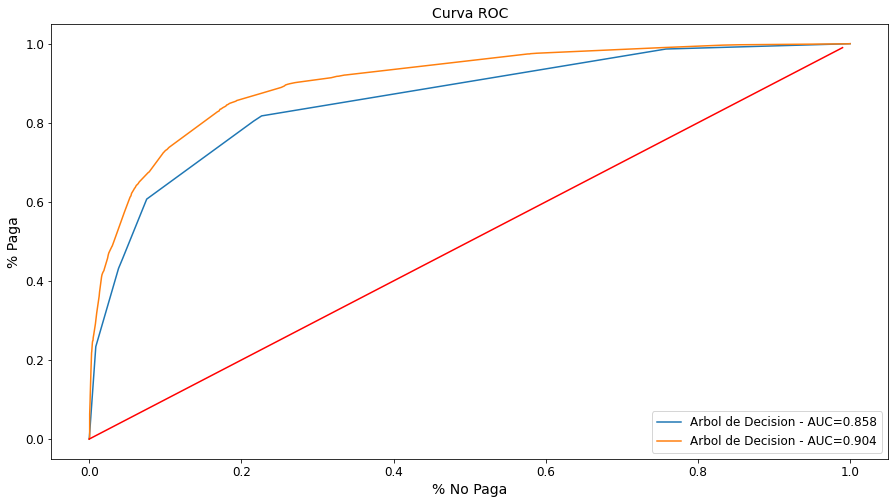

In [ ]:
plt.figure(figsize=(15, 8))
# Graficamos la curva roc del arbol de nivel 3
y_pred_proba = treeclf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print("AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision de 3 niveles: {}".format(auc))
plt.plot(fpr,tpr,label="Arbol de Decision - AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la curva roc del arbol de nivel 7
y_pred_proba7 = treeclf7.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba7)
auc = metrics.roc_auc_score(y_test, y_pred_proba7)
print("AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision de 7 niveles: {}".format(auc))
plt.plot(fpr,tpr,label="Arbol de Decision - AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR, AUC=0.5",color="red")

plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

Es un poco mejor, pero existe la posibilidad de que el modelo este overfitteando. Si estudiamos con detenimiento el arbol generado, vemos que los primeros niveles siguen siendo en su mayoria las mismas variables

### Comparación sin las variables agregadas
El siguiente paso sería comparar el desempeño de los modelos entrenados con las variables agregadas y sin ellas

#### Entrenamos los modelos

In [ ]:
df_x2 = preparacion_de_datos( df_c, True,True, False)

# Encodeamos todos los atributos categóricos como booleanos con la función pd.get_dummies (sin incluir la variable objetivo). 
X2  = pd.get_dummies(df_x2.drop(['CLASE_NUM'], axis=1))
atributos = X2.columns

# Encodeamos las etiquetas usando LabelEncoder
# Convertimos la variable objetivo en una variable booleana de valores 0 o 1 para simplificar los cálculos

y2 = le.fit_transform(df_x2['CLASE_NUM'])

# Dividimos el dataset en entrenamiento y prueba (70% para training y 30% para testing)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, 
                                                    y2, 
                                                    test_size=0.3, 
                                                    random_state=42)

X_train2.head(5)

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,es_mensual,probabilidad_pais,probabilidad_zona
id,,,,,,,,,,
QanvXCJB+ouqcQiwcEw/Xw==,-34.413843,-58.846868,-1.0,4.0,5.0,439.000000,352.000000,0,23.13,58.540549
TjWMJkQbrNlJkAF0EhviAg==,-34.636771,-59.378432,-1.0,-1.0,2.0,513.777037,238.344333,0,23.13,58.360584
cxXDQHtqbdfqyvorRIIEdg==,-34.552052,-58.732590,3.0,-1.0,3.0,180.000000,180.000000,0,23.13,58.540549
BeyrxMQheFV1LyJUYwCAjQ==,-34.794012,-58.145542,4.0,3.0,3.0,300.000000,238.344333,1,23.13,84.591101
3QyeIOpnPUdefRMvOhRSzQ==,-34.435997,-58.646104,4.0,3.0,3.0,514.000000,200.000000,1,23.13,58.540549


In [ ]:
X_scaled2 = escalar(X_train2)
X_test_scaled2 = escalar(X_test2)

In [ ]:
#Arbol
treeclf2 = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf2.fit(X_train2, y_train2)
#Regresion 
RegLog2 = LogisticRegression()
RegLog2.fit(X_scaled2,y_train2)
#Bayes
bayes2 = GaussianNB() 
bayes2.fit(X_scaled2,y_train2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GaussianNB(priors=None, var_smoothing=1e-09)

#### Comparacion por curva ROC

AUC - Area Under the Curve - Área Bajo la Curva Naive Bayes 1: 0.684995830143274
AUC - Area Under the Curve - Área Bajo la Curva Naive Bayes 2: 0.6637285930268964
AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision 1: 0.8575400852902622
AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision 2: 0.8625061423293493
AUC - Area Under the Curve - Área Bajo la Curva Modelo de Regresion: 0.8660654769494609
AUC - Area Under the Curve - Área Bajo la Curva Modelo de Regresion 2: 0.856392978886377


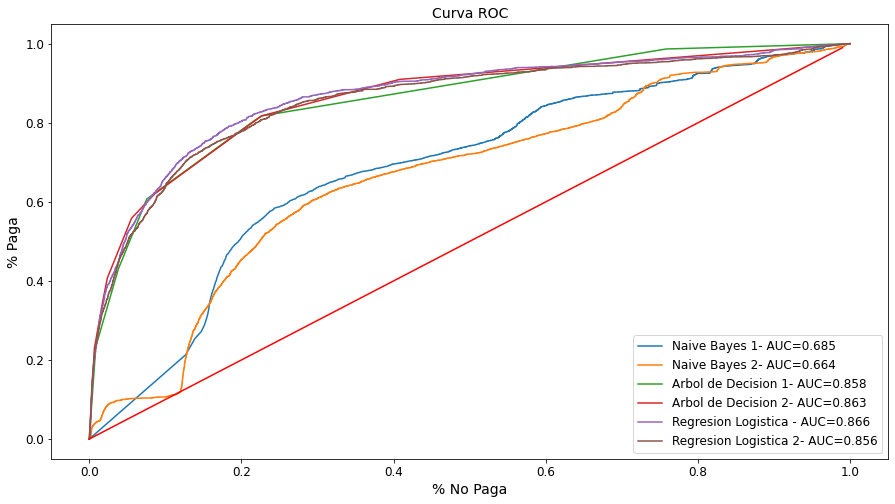

In [ ]:
plt.figure(figsize=(15, 8))

# Graficamos la curva roc del modelo Naive Bayes
y_pred_bay = bayes.predict_proba(X_test_s)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_bay)
auc = metrics.roc_auc_score(y_test, y_pred_bay)
print("AUC - Area Under the Curve - Área Bajo la Curva Naive Bayes 1: {}".format(auc))
plt.plot(fpr,tpr,label="Naive Bayes 1- AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la curva roc del modelo Naive Bayes 2
y_pred_bay2 = bayes2.predict_proba(X_test_scaled2)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test2,  y_pred_bay2)
auc = metrics.roc_auc_score(y_test, y_pred_bay2)
print("AUC - Area Under the Curve - Área Bajo la Curva Naive Bayes 2: {}".format(auc))
plt.plot(fpr,tpr,label="Naive Bayes 2- AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la curva roc del arbol
y_pred_proba = treeclf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print("AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision 1: {}".format(auc))
plt.plot(fpr,tpr,label="Arbol de Decision 1- AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la curva roc del arbol 2
y_pred_proba2 = treeclf2.predict_proba(X_test2)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test2,  y_pred_proba2)
auc = metrics.roc_auc_score(y_test2, y_pred_proba2)
print("AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision 2: {}".format(auc))
plt.plot(fpr,tpr,label="Arbol de Decision 2- AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la curva roc del modelo de regresion
y_pred_RLog = RegLog.predict_proba(X_test_s)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_RLog)
auc = metrics.roc_auc_score(y_test, y_pred_RLog)
print("AUC - Area Under the Curve - Área Bajo la Curva Modelo de Regresion: {}".format(auc))
plt.plot(fpr,tpr,label="Regresion Logistica - AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la curva roc del modelo de regresion2
y_pred_RLog2 = RegLog2.predict_proba(X_test_scaled2)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_RLog2)
auc = metrics.roc_auc_score(y_test, y_pred_RLog2)
print("AUC - Area Under the Curve - Área Bajo la Curva Modelo de Regresion 2: {}".format(auc))
plt.plot(fpr,tpr,label="Regresion Logistica 2- AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR, AUC=0.5",color="red")

plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

Concluimos entonces que descartar estas variables no mejorara el desempeño de los modelos, ya que los tres modelos se comportan de forma muy similar. Con una tendencia a funcionar un poco mejor con los 

### Comparación de imputaciones de outliers
Vamos a comparar como se comporta el modelo imputando los outliers a 2 desvios de la media, 4 desvios de la media y sin imputacion de outliers, para el modelo más prometedor (el arbol de decision).

In [ ]:
df_o1 = preparacion_de_datos( df_c, True ,True, False, False, coef_outliers = 2)
df_o2 = preparacion_de_datos( df_c, True ,True, False, False, coef_outliers = 4)
df_o3 = preparacion_de_datos( df_c, False ,True, False, False)

Xo1  = pd.get_dummies(df_o1.drop(['CLASE_NUM'], axis=1))
atributos = Xo1.columns
yo1 = le.fit_transform(df_o1['CLASE_NUM'])
# Dividimos el dataset en entrenamiento y prueba (70% para training y 30% para testing)
X_train_o1, X_test_o1, y_train_o1, y_test_o1  = train_test_split(Xo1, 
                                                    yo1, 
                                                    test_size=0.3, 
                                                    random_state=42)
###############################################################
Xo2  = pd.get_dummies(df_o2.drop(['CLASE_NUM'], axis=1))
atributos = Xo2.columns
yo2 = le.fit_transform(df_o2['CLASE_NUM'])
# Dividimos el dataset en entrenamiento y prueba (70% para training y 30% para testing)
X_train_o2, X_test_o2, y_train_o2, y_test_o2 = train_test_split(Xo2, 
                                                    yo2, 
                                                    test_size=0.3, 
                                                    random_state=42)
###############################################################
Xo3  = pd.get_dummies(df_o3.drop(['CLASE_NUM'], axis=1))
atributos = Xo3.columns
yo3 = le.fit_transform(df_o3['CLASE_NUM'])
# Dividimos el dataset en entrenamiento y prueba (70% para training y 30% para testing)
X_train_o3, X_test_o3, y_train_o3, y_test_o3 = train_test_split(Xo3, 
                                                    yo3, 
                                                    test_size=0.3, 
                                                    random_state=42)
###############################################################

In [ ]:
treeclf = DecisionTreeClassifier(max_depth=5, random_state=1)
treeclf.fit(X_train, y_train)
################################
treeclf1 = DecisionTreeClassifier(max_depth=5, random_state=1)
treeclf1.fit(X_train_o1, y_train_o1)
################################
treeclf2 = DecisionTreeClassifier(max_depth=5, random_state=1)
treeclf2.fit(X_train_o2, y_train_o2)
################################
treeclf3 = DecisionTreeClassifier(max_depth=5, random_state=1)
treeclf3.fit(X_train_o3, y_train_o3)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision Normal: 0.887051474779181
AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision x2 Desvio: 0.887051474779181
AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision x4 Desvios: 0.887051474779181
AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision sin imputar nulos: 0.8815122879566287


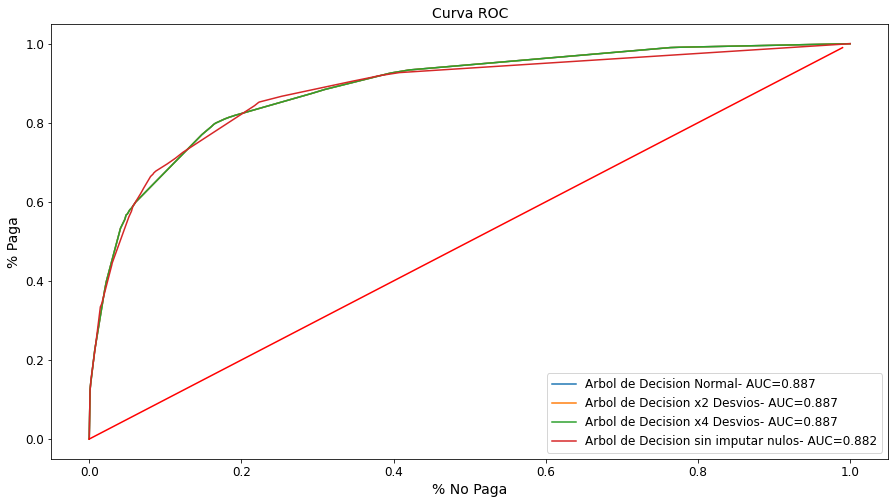

In [ ]:
plt.figure(figsize=(15, 8))

# Graficamos la curva roc del arbol
y_pred_proba = treeclf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print("AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision Normal: {}".format(auc))
plt.plot(fpr,tpr,label="Arbol de Decision Normal- AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la curva roc del arbol
y_pred_proba = treeclf1.predict_proba(X_test_o1)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_o1,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print("AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision x2 Desvio: {}".format(auc))
plt.plot(fpr,tpr,label="Arbol de Decision x2 Desvios- AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la curva roc del arbol
y_pred_proba = treeclf2.predict_proba(X_test_o2)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_o2,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print("AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision x4 Desvios: {}".format(auc))
plt.plot(fpr,tpr,label="Arbol de Decision x4 Desvios- AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la curva roc del arbol
y_pred_proba = treeclf3.predict_proba(X_test_o3)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test_o3, y_pred_proba)
print("AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision sin imputar nulos: {}".format(auc))
plt.plot(fpr,tpr,label="Arbol de Decision sin imputar nulos- AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)


# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR, AUC=0.5",color="red")

plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

#4. Funcion de ganancia y probabilidad de corte
Por cada predicción que el modelo acierte, la empresa les pagará \$100 en concepto de comisión, pero si fallan y cobran una comisión que no deberían,deben darle a Business Prop SRL una compensación de \$50. 

Esta función de ganancia consiste en sumar 10 puntos por cada acierto y restar 5 puntos por cada fallo, para definir una métrica que podamos usar para la optimización del modelo. Estos puntajes nos definen una probabilidad de corte que determinan cuáles de las observaciones serán consideradas como positivas en el hecho que va a llover.

La misma puede calcularse partiendo de la función de ganancia:

> universo_total = propiedad('paga') + propiedad('no paga')
> 
> ganancia = 10 * propiedad('paga') - 5 * propiedad('no paga')

Si descomponemos el 10 como la resta (10 -5), también se podría escribir como:

> ganancia = 15 * propiedad('paga') - 5 * propiedad('paga') - 5 * propiedad('no paga')

-

Si trabajamos un poco esta función de ganancia, buscando que la ganancia generada sea mayor a 0, podemos calcular la probabilidad de corte, si tenemos que ganancia > 0, entonces:

> 15 * propiedad('paga') - 5 * propiedad('paga') - 5 * propiedad('no paga') > 0
> 
> 15 * propiedad('paga') - 5 * (propiedad('paga') + propiedad('no paga')) > 0
> 
> 15 * propiedad('paga') > 5 * (propiedad('paga') + propiedad('no paga')) 
> 
> propiedad('paga') / (propiedad('paga') + propiedad('no paga')) > 1/3
> 
> PROB('paga') > 0.33

Esta función nos indica que la probabilidad de corte es 0.333.


In [ ]:
prob_corte = float(1/3) # probabilidad de corte calculada 

#Definimos la función de ganancia a utilizar para el scoring en la búsqueda:
def funcion_ganancia(clf, X, y_true):
    y_prob_paga = clf.predict_proba(X)[:, 1]
    
    ganancia = sum([(100 if y_true[i] > 0 else -50) 
                    if y_prob_paga[i]  > prob_corte
                    else 0 
                    for i in range(len(y_prob_paga))])
    
    return ganancia

#5. GridSearch
Utilizamos GridSearch para encontrar arboles de decision alternativos, y luego utilizaremos el mejor de los estimadores generados.

### GS en una Regresion Logistica

In [ ]:
# Definimos los parametros a evaluar:

PARAMETROS = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
k_n_jobs = 2 # numero de iteraciones definidas

# Hacemos la búsqueda con GridSearchCV

model = LogisticRegression(random_state=1, max_iter=600)
gs = GridSearchCV(model, 
                  PARAMETROS, 
                  n_jobs=k_n_jobs,
                  scoring=funcion_ganancia,
                  cv=StratifiedKFold(n_splits=3,shuffle=True,random_state=1), #Cross Validation de 3 capas
                  verbose=1)
gs.fit(X_train_s, y_train)

# Mostramos los mejores resultados obtenidos

print(gs.best_estimator_)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  42 out of  42 | elapsed:   36.8s finished


LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=600,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


AUC - Area Under the Curve - Área Bajo la Curva: 0.8599787179879457
AUC - Area Under the Curve - Área Bajo la Curva GridSearch: 0.8692362712028906


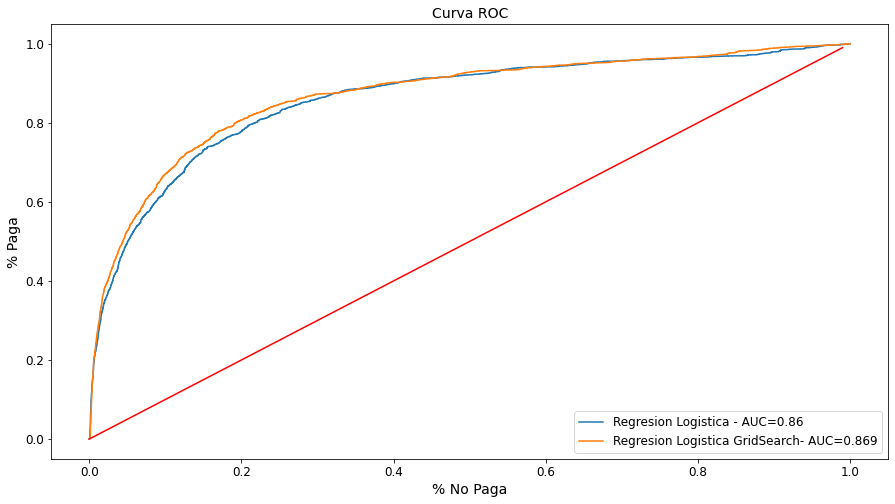

In [ ]:
plt.figure(figsize=(15, 8))
# Graficamos la curva roc del modelo de regresion
y_pred_RLog = RegLog.predict_proba(X_test_s)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_RLog)
auc = metrics.roc_auc_score(y_test, y_pred_RLog)
print("AUC - Area Under the Curve - Área Bajo la Curva: {}".format(auc))
plt.plot(fpr,tpr,label="Regresion Logistica - AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la curva roc del modelo de regresion optimizado
y_pred_RLgs = gs.best_estimator_.predict_proba(X_test_s)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_RLgs)
auc = metrics.roc_auc_score(y_test, y_pred_RLgs)
print("AUC - Area Under the Curve - Área Bajo la Curva GridSearch: {}".format(auc))
plt.plot(fpr,tpr,label="Regresion Logistica GridSearch- AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR, AUC=0.5",color="red")

plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

podemos ver que el modelo optimizado tiene una pendiente mucho más marcada al principio de la curva, lo cual es exactamente lo que buscamos cuando definimos nuestra propia funcion de ganancia.

### GS en un Arbol de Decision

#### Planteamos arboles GridSearch con opciones alternativas

In [ ]:
df_o1 = preparacion_de_datos( df_c, True ,True, False, False, coef_outliers = 2)
df_o2 = preparacion_de_datos( df_c, True ,True, False, False, coef_outliers = 3)
df_o3 = preparacion_de_datos( df_c, True ,True, False, False, coef_outliers = 4)
df_o4 = preparacion_de_datos( df_c, False ,True, False, False)
df_o5 = preparacion_de_datos( df_c, False, True, False, True)
###############################################################
Xo1  = pd.get_dummies(df_o1.drop(['CLASE_NUM'], axis=1))
atributos = Xo1.columns
yo1 = le.fit_transform(df_o1['CLASE_NUM'])
# Dividimos el dataset en entrenamiento y prueba (70% para training y 30% para testing)
X_train_o1, X_test_o1, y_train_o1, y_test_o1  = train_test_split(Xo1, 
                                                    yo1, 
                                                    test_size=0.3, 
                                                    random_state=42)
###############################################################
Xo2  = pd.get_dummies(df_o2.drop(['CLASE_NUM'], axis=1))
atributos = Xo2.columns
yo2 = le.fit_transform(df_o2['CLASE_NUM'])
# Dividimos el dataset en entrenamiento y prueba (70% para training y 30% para testing)
X_train_o2, X_test_o2, y_train_o2, y_test_o2 = train_test_split(Xo2, 
                                                    yo2, 
                                                    test_size=0.3, 
                                                    random_state=42)
###############################################################
Xo3  = pd.get_dummies(df_o3.drop(['CLASE_NUM'], axis=1))
atributos = Xo3.columns
yo3 = le.fit_transform(df_o3['CLASE_NUM'])
# Dividimos el dataset en entrenamiento y prueba (70% para training y 30% para testing)
X_train_o3, X_test_o3, y_train_o3, y_test_o3 = train_test_split(Xo3, 
                                                    yo3, 
                                                    test_size=0.3, 
                                                    random_state=42)
###############################################################
Xo4  = pd.get_dummies(df_o4.drop(['CLASE_NUM'], axis=1))
atributos = Xo4.columns
yo4 = le.fit_transform(df_o4['CLASE_NUM'])
# Dividimos el dataset en entrenamiento y prueba (70% para training y 30% para testing)
X_train_o4, X_test_o4, y_train_o4, y_test_o4 = train_test_split(Xo4, 
                                                    yo4, 
                                                    test_size=0.3, 
                                                    random_state=42)
###############################################################
Xo5  = pd.get_dummies(df_o5.drop(['CLASE_NUM'], axis=1))
atributos = Xo5.columns
yo5 = le.fit_transform(df_o5['CLASE_NUM'])
# Dividimos el dataset en entrenamiento y prueba (70% para training y 30% para testing)
X_train_o5, X_test_o5, y_train_o5, y_test_o5 = train_test_split(Xo5, 
                                                    yo5, 
                                                    test_size=0.3, 
                                                    random_state=42)
###############################################################

In [ ]:
# Definimos los parametros a evaluar:

PARAMETROS = {'max_depth':[10, 12, 15], 
              'max_features': [48,49,50], 
              'max_leaf_nodes':[30, 75 ,120], 
              'min_samples_leaf':[30, 50, 100],
              'min_samples_split':[50, 100, 200]}

k_n_jobs = 2 # numero de iteraciones definidas

# Hacemos la búsqueda con GridSearchCV

model = DecisionTreeClassifier(random_state=1)  # modelo de árbol de decision, podría ser cualquier otro o iterar una lista de modelos para probar y sus parametros
gs_arbol_o = GridSearchCV(model, 
                  PARAMETROS, 
                  n_jobs=k_n_jobs,
                  scoring=funcion_ganancia,
                  cv=StratifiedKFold(n_splits=3,shuffle=True,random_state=1), #Cross Validation de 3 capas
                  verbose=1)

In [ ]:
gs_arbol_o1 = copy.copy(gs_arbol_o )
gs_arbol_o1.fit(X_train_o1, y_train_o1)
print(gs_arbol_o1.best_estimator_)
print("el modelo 1 acerto " + str((np.mean(gs_arbol_o1.best_estimator_.predict(X_test_o1) == y_test_o1))*100) + "% de los casos")
####################################
gs_arbol_o2 = copy.copy(gs_arbol_o )
gs_arbol_o2.fit(X_train_o2, y_train_o2)
print(gs_arbol_o2.best_estimator_)
print("el modelo 2 acerto " + str((np.mean(gs_arbol_o2.best_estimator_.predict(X_test_o2) == y_test_o2))*100) + "% de los casos")
####################################
gs_arbol_o3 = copy.copy(gs_arbol_o )
gs_arbol_o3.fit(X_train_o3, y_train_o3)
print(gs_arbol_o3.best_estimator_)
print("el modelo 3 acerto " + str((np.mean(gs_arbol_o3.best_estimator_.predict(X_test_o3) == y_test_o3))*100) + "% de los casos")
####################################
gs_arbol_o4 = copy.copy(gs_arbol_o )
gs_arbol_o4.fit(X_train_o4, y_train_o4)
print(gs_arbol_o4.best_estimator_)
print("el modelo 4 acerto " + str((np.mean(gs_arbol_o4.best_estimator_.predict(X_test_o4) == y_test_o4))*100) + "% de los casos")
####################################
PARAMETROS2 = {'max_depth':[10, 12, 15], 
              'max_features': [8,9,10], 
              'max_leaf_nodes':[30, 75 ,120], 
              'min_samples_leaf':[30, 50, 100],
              'min_samples_split':[50, 100, 200]}
model = DecisionTreeClassifier(random_state=1)  # modelo de árbol de decision, podría ser cualquier otro o iterar una lista de modelos para probar y sus parametros
gs_arbol_o5 = GridSearchCV(model, 
                  PARAMETROS2, 
                  n_jobs=k_n_jobs,
                  scoring=funcion_ganancia,
                  cv=StratifiedKFold(n_splits=3,shuffle=True,random_state=1), #Cross Validation de 3 capas
                  verbose=1)
gs_arbol_o5.fit(X_train_o5, y_train_o5)
print(gs_arbol_o5.best_estimator_)
print("el modelo 5 acerto " + str((np.mean(gs_arbol_o5.best_estimator_.predict(X_test_o5) == y_test_o5))*100) + "% de los casos")
####################################

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   33.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 729 out of 729 | elapsed:  2.1min finished


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features=48, max_leaf_nodes=120,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')
el modelo 1 acerto 87.91575252303642% de los casos
Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   32.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 729 out of 729 | elapsed:  2.1min finished


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features=50, max_leaf_nodes=120,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')
el modelo 2 acerto 87.64370337867486% de los casos
Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   33.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 729 out of 729 | elapsed:  2.1min finished


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features=50, max_leaf_nodes=120,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')
el modelo 3 acerto 87.64370337867486% de los casos
Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   32.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 729 out of 729 | elapsed:  2.0min finished


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features=48, max_leaf_nodes=120,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')
el modelo 4 acerto 87.48573935936814% de los casos
Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    7.8s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   35.8s
[Parallel(n_jobs=2)]: Done 726 out of 729 | elapsed:  1.1min remaining:    0.3s
[Parallel(n_jobs=2)]: Done 729 out of 729 | elapsed:  1.1min finished


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features=9, max_leaf_nodes=120,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')
el modelo 5 acerto 87.55155770074595% de los casos


AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision: 0.8575400852902622
AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision 1: 0.9097141834807021
AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision 2: 0.9111307681312973
AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision 3: 0.9111307681312973
AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision 4: 0.907018385861227
AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision 5: 0.9084878162937344


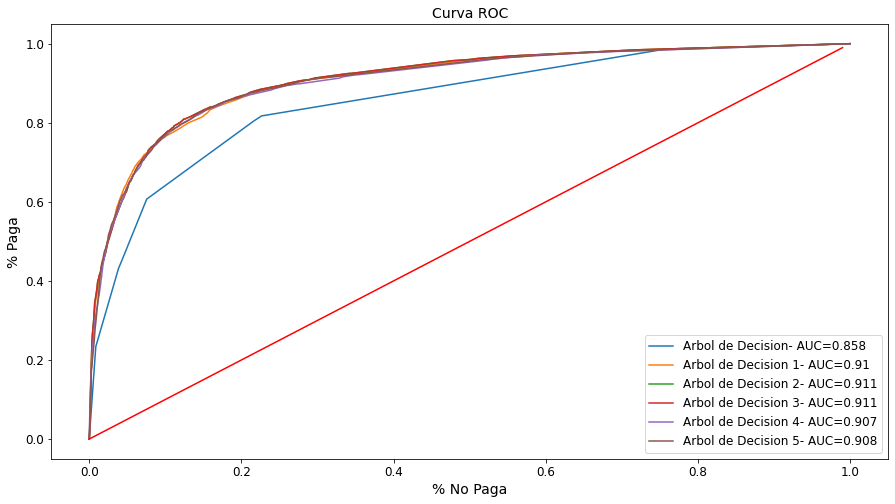

In [ ]:
plt.figure(figsize=(15, 8))

# Graficamos la curva roc del arbol de 3 niveles
y_pred_proba = treeclf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print("AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision: {}".format(auc))
plt.plot(fpr,tpr,label="Arbol de Decision 1- AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la curva roc del arbol 1
y_pred_proba = gs_arbol_o1.best_estimator_.predict_proba(X_test_o1)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_o1,  y_pred_proba)
auc = metrics.roc_auc_score(y_test_o1, y_pred_proba)
print("AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision 1: {}".format(auc))
plt.plot(fpr,tpr,label="Arbol de Decision 1- AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)
# Graficamos la curva roc del arbol 2
y_pred_proba = gs_arbol_o2.best_estimator_.predict_proba(X_test_o2)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_o2,  y_pred_proba)
auc = metrics.roc_auc_score(y_test_o2, y_pred_proba)
print("AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision 2: {}".format(auc))
plt.plot(fpr,tpr,label="Arbol de Decision 2- AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)
# Graficamos la curva roc del arbol 3
y_pred_proba = gs_arbol_o3.best_estimator_.predict_proba(X_test_o3)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_o3,  y_pred_proba)
auc = metrics.roc_auc_score(y_test_o3, y_pred_proba)
print("AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision 3: {}".format(auc))
plt.plot(fpr,tpr,label="Arbol de Decision 3- AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)
# Graficamos la curva roc del arbol 4
y_pred_proba = gs_arbol_o4.best_estimator_.predict_proba(X_test_o4)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_o4,  y_pred_proba)
auc = metrics.roc_auc_score(y_test_o4, y_pred_proba)
print("AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision 4: {}".format(auc))
plt.plot(fpr,tpr,label="Arbol de Decision 4- AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)
# Graficamos la curva roc del arbol 5
y_pred_proba = gs_arbol_o5.best_estimator_.predict_proba(X_test_o5)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_o5,  y_pred_proba)
auc = metrics.roc_auc_score(y_test_o5, y_pred_proba)
print("AUC - Area Under the Curve - Área Bajo la Curva Arbol de Decision 5: {}".format(auc))
plt.plot(fpr,tpr,label="Arbol de Decision 5- AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR, AUC=0.5",color="red")

plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

#### GS del mejor Arbol Posible

In [ ]:
df_c = pd.read_csv(dataset_entrenamiento, sep =',', na_values = '.', parse_dates=['start_date','end_date','created_on'])
df_c['CLASE_NUM'] = list(map(lambda clase: 1 if (clase == 'paga') else 0, df['CLASE']))
df_GS = preparacion_de_datos( df_c, True ,True, False, False, coef_outliers = 3)

X  = pd.get_dummies(df_GS.drop(['CLASE_NUM'], axis=1))
atributos = X.columns
y = le.fit_transform(df_GS['CLASE_NUM'])
# Dividimos el dataset en entrenamiento y prueba (70% para training y 30% para testing)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [ ]:
# Definimos los parametros a evaluar:

PARAMETROS = {'max_depth':[5, 8, 10, 12, 15, 17 ,19], 
              'max_features': range(9,len(X_train.columns),3), 
              'max_leaf_nodes':[30, 50, 90, 120], 
              'min_samples_leaf':[20, 30, 50, 75, 100, 150],
              'min_samples_split':[50, 75, 100, 300]}

#PARAMETROS = {'max_depth':[5, 8, 10, 12, 15, 18], 
#              'max_features':[10, 20, 40, 45 ,48, 50, 51], 
#              'max_leaf_nodes':[30, 50, 90, 100, 120], 
#              'min_samples_leaf':[50, 100, 150, 200],
#              'min_samples_split':[100, 200, 300, 400]
#              }

k_n_jobs = 4 # numero de iteraciones definidas

# Hacemos la búsqueda con GridSearchCV

model = DecisionTreeClassifier(random_state=1)  # modelo de árbol de decision, podría ser cualquier otro o iterar una lista de modelos para probar y sus parametros
gs_arbol = GridSearchCV(model, 
                  PARAMETROS, 
                  n_jobs=k_n_jobs,
                  scoring=funcion_ganancia,
                  cv=StratifiedKFold(n_splits=3,shuffle=True,random_state=1), #Cross Validation de 3 capas
                  verbose=1) 
gs_arbol.fit(X_train, y_train)

# Mostramos los mejores resultados obtenidos

print(gs_arbol.best_estimator_)

Fitting 3 folds for each of 9408 candidates, totalling 28224 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   34.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  7.1min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed:  8.5min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed: 10.6min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed: 13.3min
[Parallel(n_jobs=4)]: Done 8442 tasks      | elapsed: 16.4min
[Parallel(n_jobs=4)]: Done 9792 tasks      | elapsed: 18.9min
[Parallel(n_jobs=4)]: Done 11242 tasks      | elapsed: 22.4mi

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=17, max_features=48, max_leaf_nodes=120,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')


In [ ]:
print(gs_arbol.best_estimator_)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=17, max_features=48, max_leaf_nodes=120,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')


In [ ]:
len(X_train.columns)

51

#### visualizacion del mejor estimador

In [ ]:
# Visualizamos el mejor árbol de decisión generado usando graphviz
dot_data=export_graphviz(gs_arbol.best_estimator_, 
                         out_file=None,
                         feature_names=X.columns,  
                         filled=True, rounded=True,
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())  

Output hidden; open in https://colab.research.google.com to view.

#### Analisis del mejor estimador
Vemos que este estimador prioriza la superficie cubierta y los baños como el anterior, pero tambien le da alguna importancia a las otras variables brindadas.

In [ ]:
atributos = pd.get_dummies(X_train).columns
pd.DataFrame({'Atributo':atributos,
              'importancia':gs_arbol.best_estimator_.feature_importances_}).sort_values('importancia',
                                                                       ascending=False).head(15)

,Atributo,importancia
4,bathrooms,0.509941
6,surface_covered,0.272479
1,lon,0.066818
0,lat,0.066246
12,l2_Bs.As. G.B.A. Zona Norte,0.030205
18,l2_Capital Federal,0.017067
11,l1_Uruguay,0.008558
7,es_mensual,0.007415
5,surface_total,0.007073
2,rooms,0.006975


### GS en knn

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

PARAMETROS = {'n_neighbors': range(5,10,1),
              'leaf_size': [ 50, 100, 200, 500]
}

#PARAMETROS = {'n_neighbors': [5, 10, 20, 30, 40]}
k_n_jobs = 2

#X_train_sc = sc.fit_transform(X_train)
#X_test_sc = sc.transform(X_test)

X_train_s = escalar(X_train)
X_test_s = escalar(X_test)

model = KNeighborsClassifier()
gs_knn = GridSearchCV(model, PARAMETROS, verbose=1, scoring=funcion_ganancia, n_jobs=k_n_jobs,
                      cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=1)) 
gs_knn.fit(X_train_s, y_train)




print(gs_knn.best_estimator_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  5.8min
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  8.2min finished


KNeighborsClassifier(algorithm='auto', leaf_size=50, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')


### Comparacion entre los modelos

#### Curva ROC

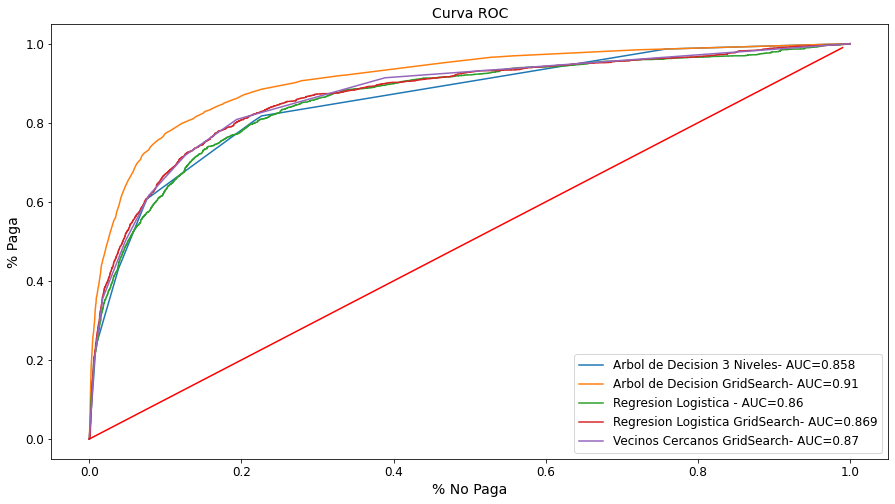

In [ ]:
plt.figure(figsize=(15, 8))

# Graficamos la curva roc del arbol inicial
y_pred_proba = treeclf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Arbol de Decision 3 Niveles- AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la curva roc del arbol optimizado
y_pred_proba = gs_arbol.best_estimator_.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Arbol de Decision GridSearch- AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la curva roc del modelo de regresion
y_pred_RLog = RegLog.predict_proba(X_test_s)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_RLog)
auc = metrics.roc_auc_score(y_test, y_pred_RLog)
plt.plot(fpr,tpr,label="Regresion Logistica - AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la curva roc del modelo de regresion optimizado
y_pred_RLgs = gs.best_estimator_.predict_proba(X_test_s)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_RLgs)
auc = metrics.roc_auc_score(y_test, y_pred_RLgs)
plt.plot(fpr,tpr,label="Regresion Logistica GridSearch- AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la curva roc del modelo knn optimizado
y_pred_RLgs = gs_knn.best_estimator_.predict_proba(X_test_s)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_RLgs)
auc = metrics.roc_auc_score(y_test, y_pred_RLgs)
plt.plot(fpr,tpr,label="Vecinos Cercanos GridSearch- AUC="+str(round(auc,3)))
plt.xlabel('% No Paga', fontsize=14)
plt.ylabel('% Paga', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR, AUC=0.5",color="red")

plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

#6. Aplicacion del modelo a Datos nuevos


### Aplicacion del modelo
Luego de realizar algunas pruebas decidimos que el modelo con el que generaremos la prediccion será el mejor estimador generado por GridSearch con la estrategia de arbol de decision.

No utilizaremos las variables generadas por nosotros para l1 y l2, y nos conformaremos con las variables dummies que demostraron tener un mejor desempeño.
Ademas imputamos los outliers a la media + 3 x varianza, porque las otras imputaciones resultaron iguales o peores y los nulos con valores invalidos como -1.


In [ ]:
# Leemos el dataset de aplicacion, para predecir la comision en casos que desconocemos el futuro.
dataset_aplicacion='https://raw.githubusercontent.com/unlam-fcdin/UNLaM_FCDIN/master/casas_predecir.csv'
coso = pd.read_csv(dataset_aplicacion, sep =',', na_values = '.', parse_dates=['start_date','end_date','created_on'])

# Siempre el primer paso es ejecutar la función de preparacion de datos que construimos
df_apply = preparacion_de_datos(coso, True ,True, False, False, coef_outliers = 3)
df_apply  = pd.get_dummies(df_apply)
#df_apply_s = escalar(df_apply)
# Veamos como quedó el dataset
df_apply.head(10)

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,es_mensual,l1_Argentina,l1_Brasil,l1_Estados Unidos,l1_Uruguay,l2_Bs.As. G.B.A. Zona Norte,l2_Bs.As. G.B.A. Zona Oeste,l2_Bs.As. G.B.A. Zona Sur,l2_Buenos Aires Costa Atlántica,l2_Buenos Aires Interior,l2_Canelones,l2_Capital Federal,l2_Catamarca,l2_Chaco,l2_Chubut,l2_Colonia,l2_Corrientes,l2_Córdoba,l2_Entre Ríos,l2_Florida,l2_Formosa,l2_Jujuy,l2_La Pampa,l2_La Rioja,l2_Maldonado,l2_Maryland,l2_Mendoza,l2_Miami,l2_Michigan,l2_Misiones,l2_Montevideo,l2_Neuquén,l2_Pennsylvania,l2_Rocha,l2_Río Negro,l2_Salta,l2_San Juan,l2_San Luis,l2_Santa Catarina,l2_Santa Cruz,l2_Santa Fe,l2_Santiago Del Estero,l2_Tierra Del Fuego,l2_Tucumán
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
aB4Tzs+i8CyPrCWnMDzyuQ==,-34.654981,-58.512033,4.0,3.0,2.0,230.000000,150.000000,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
xshJ/D9SD1RCa9oXC1wcXA==,-34.554117,-58.703095,4.0,3.0,-1.0,527.840568,240.459835,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
+A53TXdhcSpnxLrmmcPcOQ==,-34.655027,-58.797475,4.0,3.0,1.0,527.840568,120.000000,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
mL/E9o7YbmC3oBflV2Gqqg==,-34.361370,-58.750782,3.0,-1.0,3.0,152.000000,152.000000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
R1d7EcMGEGgtXtlOI3C6eQ==,-34.828623,-58.393334,1.0,0.0,-1.0,527.840568,240.459835,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Ng6v413uoRlieXr2CvgRzQ==,-34.644633,-58.810363,-1.0,-1.0,1.0,527.840568,240.459835,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
69CYDSnwBwW29TLO5h2QxQ==,-34.793119,-58.423070,5.0,4.0,2.0,527.840568,240.459835,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
oGUC1UK2FZzz1gUPiulIVg==,-34.356931,-58.777089,3.0,3.0,2.0,190.000000,160.000000,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ofUKArHY35NGvSUb6Crjnw==,-34.638297,-58.454699,4.0,-1.0,1.0,128.000000,124.000000,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
atributos = df_apply.columns

# Aplicamos la predicción al nuevo dataset
scores = gs_arbol.best_estimator_.predict_proba(df_apply)
# Agregamos al dataset la probabilidad de pagar predicha con el modelo
df_result = copy.copy(df_apply)
df_result['PROB'] = scores[:,1]

# Veamos como quedó:
df_result.sort_values(by='PROB', ascending=False).head(15)

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,es_mensual,l1_Argentina,l1_Brasil,l1_Estados Unidos,l1_Uruguay,l2_Bs.As. G.B.A. Zona Norte,l2_Bs.As. G.B.A. Zona Oeste,l2_Bs.As. G.B.A. Zona Sur,l2_Buenos Aires Costa Atlántica,l2_Buenos Aires Interior,l2_Canelones,l2_Capital Federal,l2_Catamarca,l2_Chaco,l2_Chubut,l2_Colonia,l2_Corrientes,l2_Córdoba,l2_Entre Ríos,l2_Florida,l2_Formosa,l2_Jujuy,l2_La Pampa,l2_La Rioja,l2_Maldonado,l2_Maryland,l2_Mendoza,l2_Miami,l2_Michigan,l2_Misiones,l2_Montevideo,l2_Neuquén,l2_Pennsylvania,l2_Rocha,l2_Río Negro,l2_Salta,l2_San Juan,l2_San Luis,l2_Santa Catarina,l2_Santa Cruz,l2_Santa Fe,l2_Santiago Del Estero,l2_Tierra Del Fuego,l2_Tucumán,PROB
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5dlnMXnK+RSL7a639oBemQ==,-37.945473,-57.583519,-1.0,-1.0,3.0,527.840568,240.459835,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
fr7mi1DDwUHT6oj1YDNLvQ==,-37.945473,-57.583519,-1.0,-1.0,3.0,527.840568,240.459835,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
clzQONgC3XiiOSzqSqrOPw==,-37.945473,-57.583519,-1.0,-1.0,3.0,527.840568,240.459835,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
55s/sOhAfYZWaGYfhLv+9w==,-37.945473,-57.583519,-1.0,-1.0,3.0,527.840568,240.459835,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
GQnaijCWncG85ffoQvq0bw==,-37.945473,-57.583519,-1.0,-1.0,3.0,527.840568,240.459835,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
u/hU0kpbOdhkdp4zbJBMSA==,-37.945473,-57.583519,-1.0,-1.0,3.0,527.840568,240.459835,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
TKX4XgmYs+j51FyWve3yAA==,-37.945473,-57.583519,-1.0,-1.0,3.0,527.840568,240.459835,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
zLI8mBfwnOEocKYF5GpvCw==,-37.945473,-57.583519,-1.0,-1.0,3.0,527.840568,240.459835,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
cIh2hTqUzcTw+Z58623E9g==,-37.945473,-57.583519,-1.0,-1.0,3.0,527.840568,240.459835,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0


#7. Entregable final

In [ ]:
dataset_entrega='dataset_entrega.csv'

# Entregamos sólo las observaciones donde predecimos que va a pagar
df_entregar = df_result[df_result.PROB > prob_corte]
df_entregar.to_csv(path_or_buf=dataset_entrega, sep=",", na_rep='.')
df_entregar.head(10)

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,es_mensual,l1_Argentina,l1_Brasil,l1_Estados Unidos,l1_Uruguay,l2_Bs.As. G.B.A. Zona Norte,l2_Bs.As. G.B.A. Zona Oeste,l2_Bs.As. G.B.A. Zona Sur,l2_Buenos Aires Costa Atlántica,l2_Buenos Aires Interior,l2_Canelones,l2_Capital Federal,l2_Catamarca,l2_Chaco,l2_Chubut,l2_Colonia,l2_Corrientes,l2_Córdoba,l2_Entre Ríos,l2_Florida,l2_Formosa,l2_Jujuy,l2_La Pampa,l2_La Rioja,l2_Maldonado,l2_Maryland,l2_Mendoza,l2_Miami,l2_Michigan,l2_Misiones,l2_Montevideo,l2_Neuquén,l2_Pennsylvania,l2_Rocha,l2_Río Negro,l2_Salta,l2_San Juan,l2_San Luis,l2_Santa Catarina,l2_Santa Cruz,l2_Santa Fe,l2_Santiago Del Estero,l2_Tierra Del Fuego,l2_Tucumán,PROB
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
aB4Tzs+i8CyPrCWnMDzyuQ==,-34.654981,-58.512033,4.000000,3.0,2.0,230.000000,150.000000,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.462500
xshJ/D9SD1RCa9oXC1wcXA==,-34.554117,-58.703095,4.000000,3.0,-1.0,527.840568,240.459835,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.888112
N+OWxOm7ulP0Ft/KMoAB2w==,-34.478933,-58.575586,-1.000000,2.0,2.0,500.000000,150.000000,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.448529
rGOfZ8o8CnKNoa3SBQPISA==,-34.438160,-58.789605,-1.000000,3.0,3.0,280.000000,230.000000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.711864
eQasj4jq1BpDFIskddXFnw==,-35.019025,-58.653447,4.000000,3.0,3.0,498.000000,332.000000,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.673640
sDrzqaCZdNOtFDF/KG1B+g==,-34.601208,-58.637018,-1.000000,-1.0,2.0,527.840568,240.459835,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.389571
5EJSn766tBg5HDMC4IPTGg==,-34.384691,-58.680872,5.000000,-1.0,3.0,527.840568,193.000000,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.920152
GiJsoz0hBvCOjEm5WnMTuA==,-34.390290,-58.710833,6.000000,4.0,4.0,260.000000,260.000000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.485915
ZXWO75NQ4QakEa7mwyTvsw==,-34.535259,-58.510597,5.000000,-1.0,3.0,220.000000,220.000000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.655172


In [ ]:
df_entregar.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,es_mensual,l1_Argentina,l1_Brasil,l1_Estados Unidos,l1_Uruguay,l2_Bs.As. G.B.A. Zona Norte,l2_Bs.As. G.B.A. Zona Oeste,l2_Bs.As. G.B.A. Zona Sur,l2_Buenos Aires Costa Atlántica,l2_Buenos Aires Interior,l2_Canelones,l2_Capital Federal,l2_Catamarca,l2_Chaco,l2_Chubut,l2_Colonia,l2_Corrientes,l2_Córdoba,l2_Entre Ríos,l2_Florida,l2_Formosa,l2_Jujuy,l2_La Pampa,l2_La Rioja,l2_Maldonado,l2_Maryland,l2_Mendoza,l2_Miami,l2_Michigan,l2_Misiones,l2_Montevideo,l2_Neuquén,l2_Pennsylvania,l2_Rocha,l2_Río Negro,l2_Salta,l2_San Juan,l2_San Luis,l2_Santa Catarina,l2_Santa Cruz,l2_Santa Fe,l2_Santiago Del Estero,l2_Tierra Del Fuego,l2_Tucumán,PROB
count,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.0,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.0,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.0,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000,15679.000000
mean,-34.414117,-59.060301,2.089115,2.136820,2.839709,556.949777,291.192946,0.490784,0.956630,0.000064,0.003572,0.039735,0.442056,0.073921,0.130876,0.082658,0.017220,0.001594,0.130557,0.0,0.000064,0.001339,0.003317,0.000383,0.030742,0.002232,0.000128,0.0,0.000128,0.000765,0.000064,0.028828,0.002169,0.004465,0.0,0.000702,0.001212,0.005804,0.005102,0.000574,0.000191,0.003827,0.002360,0.000383,0.001977,0.000064,0.000255,0.019772,0.000064,0.000064,0.004146,0.702924
std,4.662796,2.271595,3.123067,2.770363,1.771259,480.369867,206.213534,0.499931,0.203695,0.007986,0.059658,0.195341,0.496647,0.261650,0.337275,0.275374,0.130096,0.039900,0.336926,0.0,0.007986,0.036574,0.057496,0.019559,0.172623,0.047196,0.011294,0.0,0.011294,0.027655,0.007986,0.167329,0.046518,0.066670,0.0,0.026479,0.034791,0.075965,0.071251,0.023953,0.013832,0.061744,0.048522,0.019559,0.044423,0.007986,0.015971,0.139219,0.007986,0.007986,0.064255,0.206446
min,-54.823127,-83.187864,-1.000000,-1.000000,-1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.344086
25%,-34.670155,-59.378432,-1.000000,-1.000000,2.000000,350.000000,240.459835,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.552632
50%,-34.636771,-58.653983,3.000000,3.000000,3.000000,527.840568,240.459835,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.723757
75%,-34.446898,-58.455652,5.000000,4.000000,4.000000,527.840568,300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

Vemos que el csv generado tiene todos los regustos cuyo score se clasifico arriba del 0.33 (punto de corte calculado)